## Визуализация топологии жанров по эмбеддингам тактов (CQT-хрома)


In [ ]:
import os
import sys
import glob
from pathlib import Path

# Определение корня проекта для работы напрямую из ноутбука (VS Code, JupyterLab)
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        notebook_name = ipython.user_ns.get('__vsc_ipynb_file__') or ipython.user_ns.get('__file__')
        if notebook_name:
            notebook_path = Path(notebook_name).resolve()
            if 'notebooks' in str(notebook_path):
                project_root = notebook_path.parent.parent
            else:
                project_root = notebook_path.parent
        else:
            cwd = Path.cwd().resolve()
            if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
                project_root = cwd
            elif 'notebooks' in str(cwd):
                project_root = cwd.parent
            else:
                project_root = cwd
    else:
        raise AttributeError("Not in IPython")
except:
    cwd = Path.cwd().resolve()
    if (cwd / 'notebooks').exists() and (cwd / 'src').exists():
        project_root = cwd
    elif 'notebooks' in str(cwd):
        project_root = cwd.parent
    else:
        current = cwd
        while current != current.parent:
            if (current / 'notebooks').exists() and (current / 'src').exists():
                project_root = current
                break
            current = current.parent
        else:
            project_root = cwd

# Добавляем корневую директорию проекта и src/ в путь
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / 'src'))

# Проверка и вывод информации
print(f"✓ Корень проекта: {project_root}")
print(f"✓ Путь к src: {project_root / 'src'}")
print(f"✓ Текущая рабочая директория: {Path.cwd()}")

# Дополнительная проверка структуры проекта
if (project_root / 'notebooks').exists() and (project_root / 'src').exists():
    print(f"✓ Структура проекта найдена корректно")
else:
    print(f"⚠ ВНИМАНИЕ: Структура проекта не найдена!")
    print(f"  Проверьте, что папки 'notebooks' и 'src' существуют в {project_root}")

import numpy as np
import matplotlib.pyplot as plt

from src.topology_methods import cqt_chroma_bar_embeddings
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 120

## Проход по жанрам в папке top50musicSpotify


In [ ]:
# Папка с жанровыми подкаталогами (от корня репозитория)
# Используем project_root для надежности работы из любой директории
base_genre_dir = str(project_root / "data/top50musicSpotify")

# Параметры CQT-баровых эмбеддингов
bins_per_octave = 36
hop_len = 2048
n_octaves = 7
beats_per_bar = 4
aggregation = "mean"
use_auto_tempo = True
bpm = None

# Параметры t-SNE
tsne_perplexity = 50
tsne_iterations = 1000

# Параметры HDBSCAN
min_cluster_size = 30
min_samples = 5


## Функция для расчёта и визуализации t-SNE + HDBSCAN по одному жанру


In [12]:
def tsne_hdbscan_for_genre(genre_dir: str):
    """Строит t-SNE и HDBSCAN-кластеры по всем тактам жанра.

    genre_dir: путь к папке конкретного жанра (с .wav/.mp3 файлами).
    """
    audio_files = []
    audio_files.extend(glob.glob(os.path.join(genre_dir, "*.wav")))
    audio_files.extend(glob.glob(os.path.join(genre_dir, "*.mp3")))

    if not audio_files:
        print(f"Нет аудиофайлов в {genre_dir}")
        return

    all_bars = []
    file_ids = []

    for fpath in audio_files:
        try:
            bars = cqt_chroma_bar_embeddings(
                file_path=fpath,
                bins_per_octave=bins_per_octave,
                hop_len=hop_len,
                n_octaves=n_octaves,
                beats_per_bar=beats_per_bar,
                aggregation=aggregation,
                use_auto_tempo=use_auto_tempo,
                bpm=bpm,
            )
            if bars.size == 0:
                continue
            all_bars.append(bars)
            file_ids.extend([os.path.basename(fpath)] * bars.shape[0])
        except Exception as e:
            print(f"Ошибка при обработке {fpath}: {e}")

    if not all_bars:
        print(f"Не удалось получить эмбеддинги для {genre_dir}")
        return

    X = np.vstack(all_bars).astype(np.float32)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # t-SNE по стандартизированным эмбеддингам
    n_samples = X_scaled.shape[0]
    perplexity = min(tsne_perplexity, max(5, n_samples - 1))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=tsne_iterations,
        random_state=42,
        verbose=0,
    )
    X_2d = tsne.fit_transform(X_scaled)

    # HDBSCAN-кластеры на тех же стандартизированных эмбеддингах
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
    )
    labels = clusterer.fit_predict(X_scaled)

    unique_labels = np.unique(labels)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Голый t-SNE (один цвет)
    axes[0].scatter(X_2d[:, 0], X_2d[:, 1], s=8, alpha=0.7, color="tab:blue")
    axes[0].set_title("t-SNE (все такты жанра)")
    axes[0].set_xlabel("t-SNE 1")
    axes[0].set_ylabel("t-SNE 2")
    axes[0].grid(alpha=0.3)

    # 2. t-SNE + HDBSCAN (цвет по кластерам)
    cmap = plt.get_cmap("tab20")
    for lab in unique_labels:
        mask = labels == lab
        if lab == -1:
            color = "lightgray"
            label = "шум (-1)"
        else:
            color = cmap(lab % 20)
            label = f"кластер {lab}"
        axes[1].scatter(X_2d[mask, 0], X_2d[mask, 1], s=8, alpha=0.8, color=color, label=label)

    axes[1].set_title("t-SNE + HDBSCAN")
    axes[1].set_xlabel("t-SNE 1")
    axes[1].set_ylabel("t-SNE 2")
    axes[1].grid(alpha=0.3)
    if len(unique_labels) <= 20:
        axes[1].legend(fontsize=8)

    fig.suptitle(f"Жанр: {os.path.basename(genre_dir)} — тактовые CQT-хрома эмбеддинги", fontsize=14)
    plt.tight_layout()
    plt.show()


## Запуск визуализации для всех жанров в top50musicSpotify


In [13]:
# Карта жанр → путь для удобного вызова по отдельности
if not os.path.exists(base_genre_dir):
    raise FileNotFoundError(f"Базовая папка с жанрами не найдена: {base_genre_dir}")

GENRE_PATHS = {
    name: os.path.join(base_genre_dir, name)
    for name in sorted(os.listdir(base_genre_dir))
    if os.path.isdir(os.path.join(base_genre_dir, name))
}

print("Доступные жанры:", ", ".join(GENRE_PATHS.keys()))


Доступные жанры: blues, classical, country, electronic, hip-hop, jazz, metal, pop, reggae, rock


### Blues


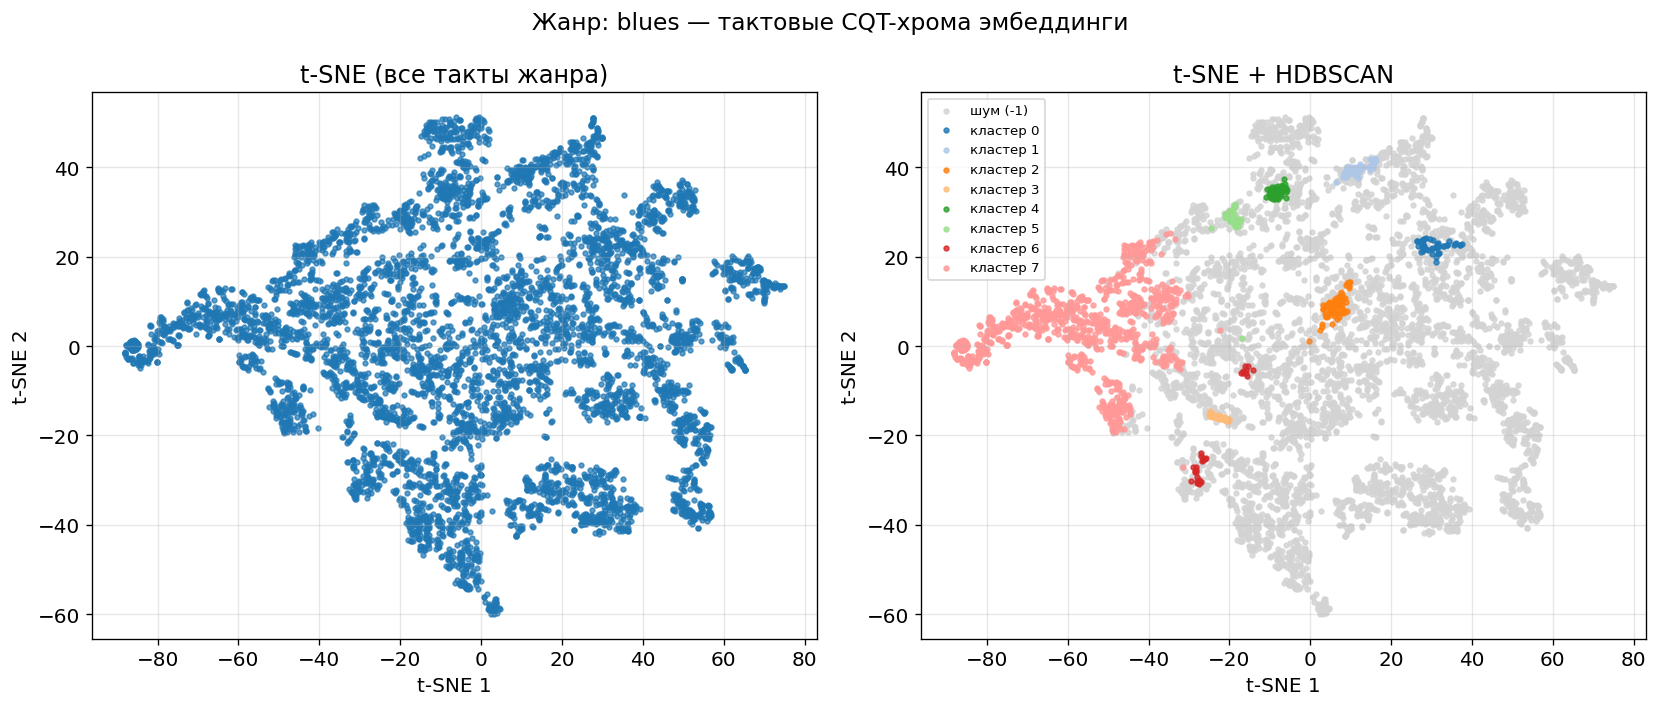

In [14]:
tsne_hdbscan_for_genre(GENRE_PATHS["blues"])


### Classical


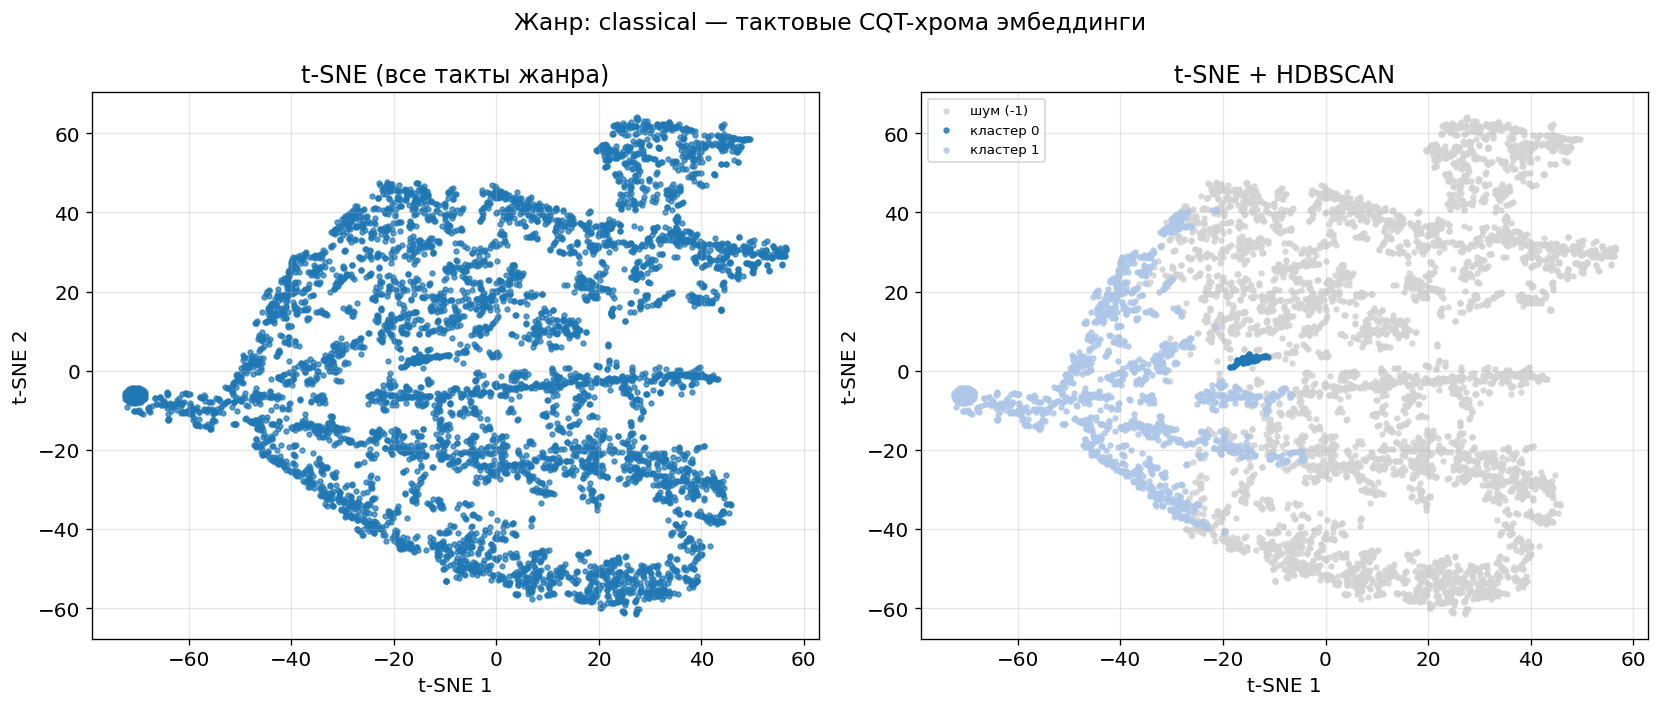

In [15]:
tsne_hdbscan_for_genre(GENRE_PATHS["classical"])


### Country


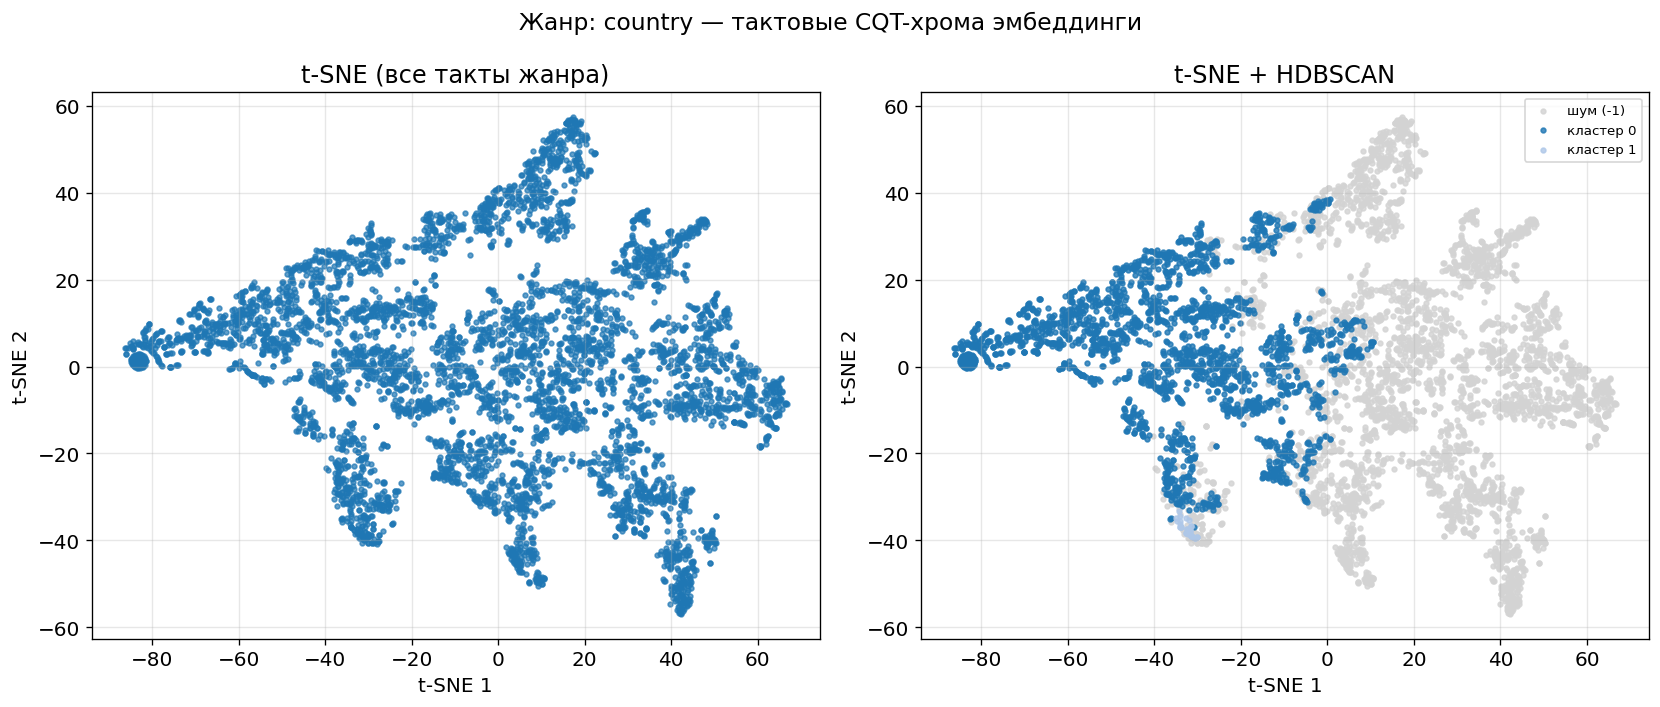

In [16]:
tsne_hdbscan_for_genre(GENRE_PATHS["country"])


### Electronic


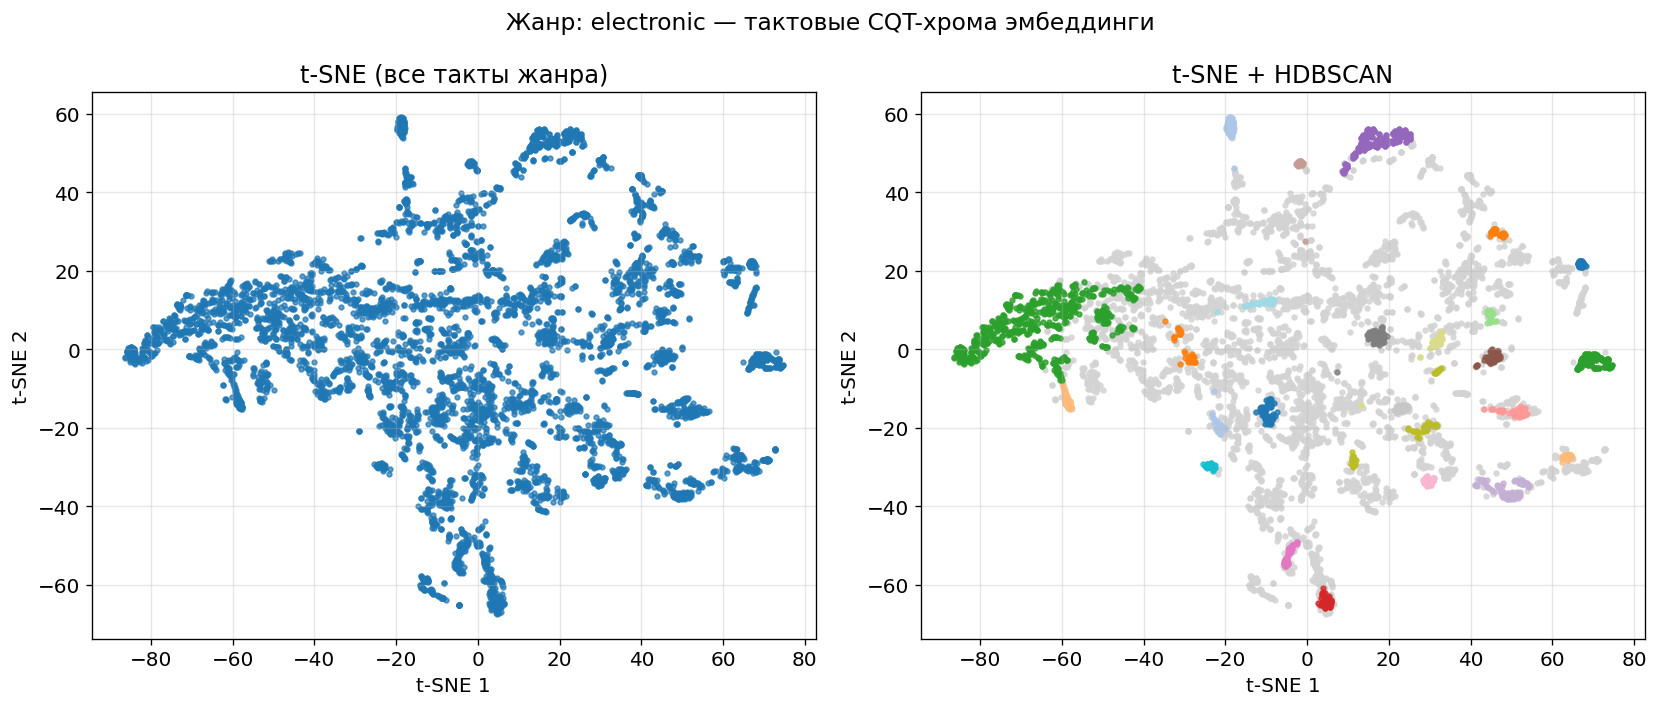

In [17]:
tsne_hdbscan_for_genre(GENRE_PATHS["electronic"])


### Hip-hop


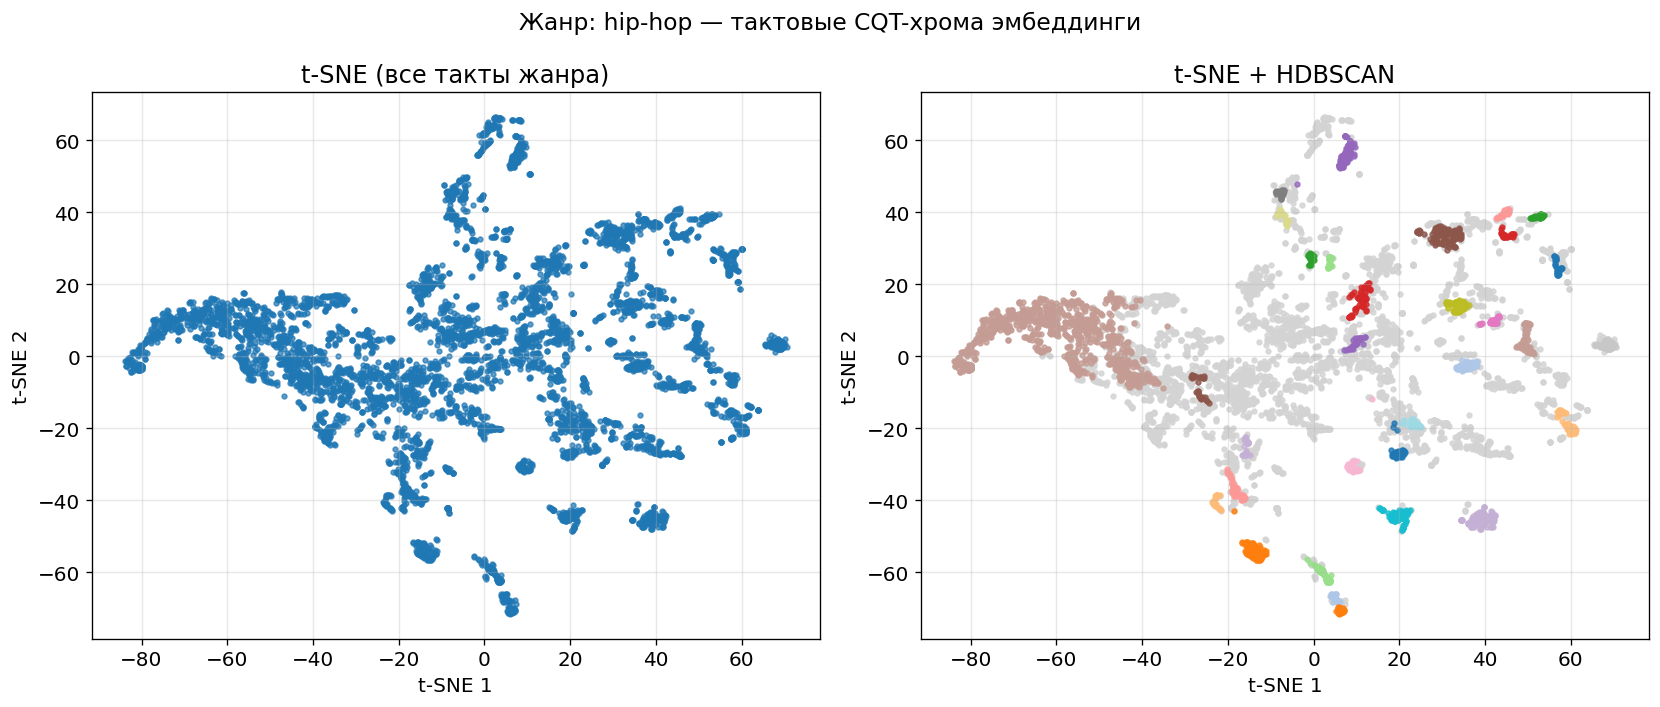

In [18]:
tsne_hdbscan_for_genre(GENRE_PATHS["hip-hop"])


### Jazz


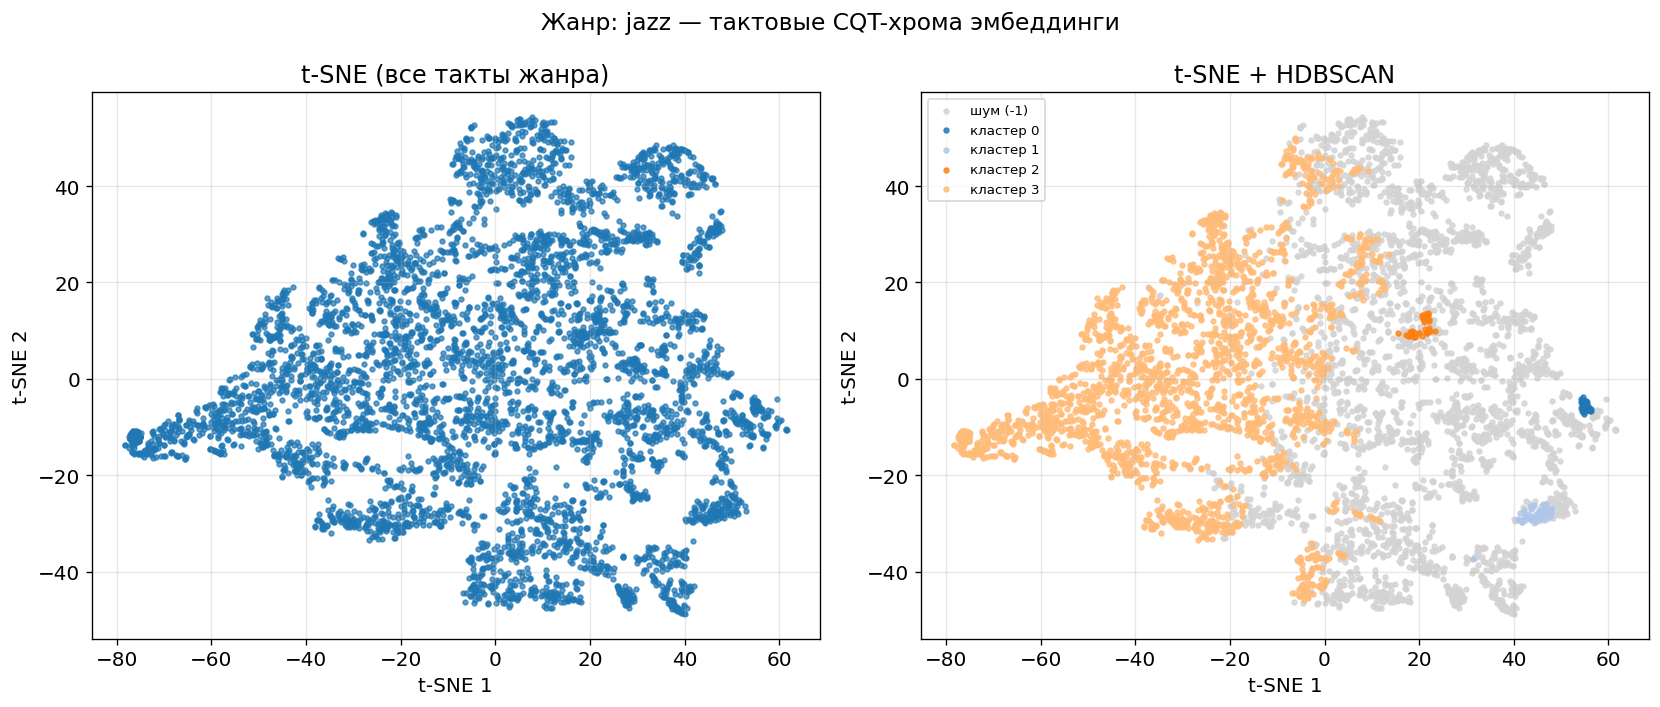

In [19]:
tsne_hdbscan_for_genre(GENRE_PATHS["jazz"])


### Metal


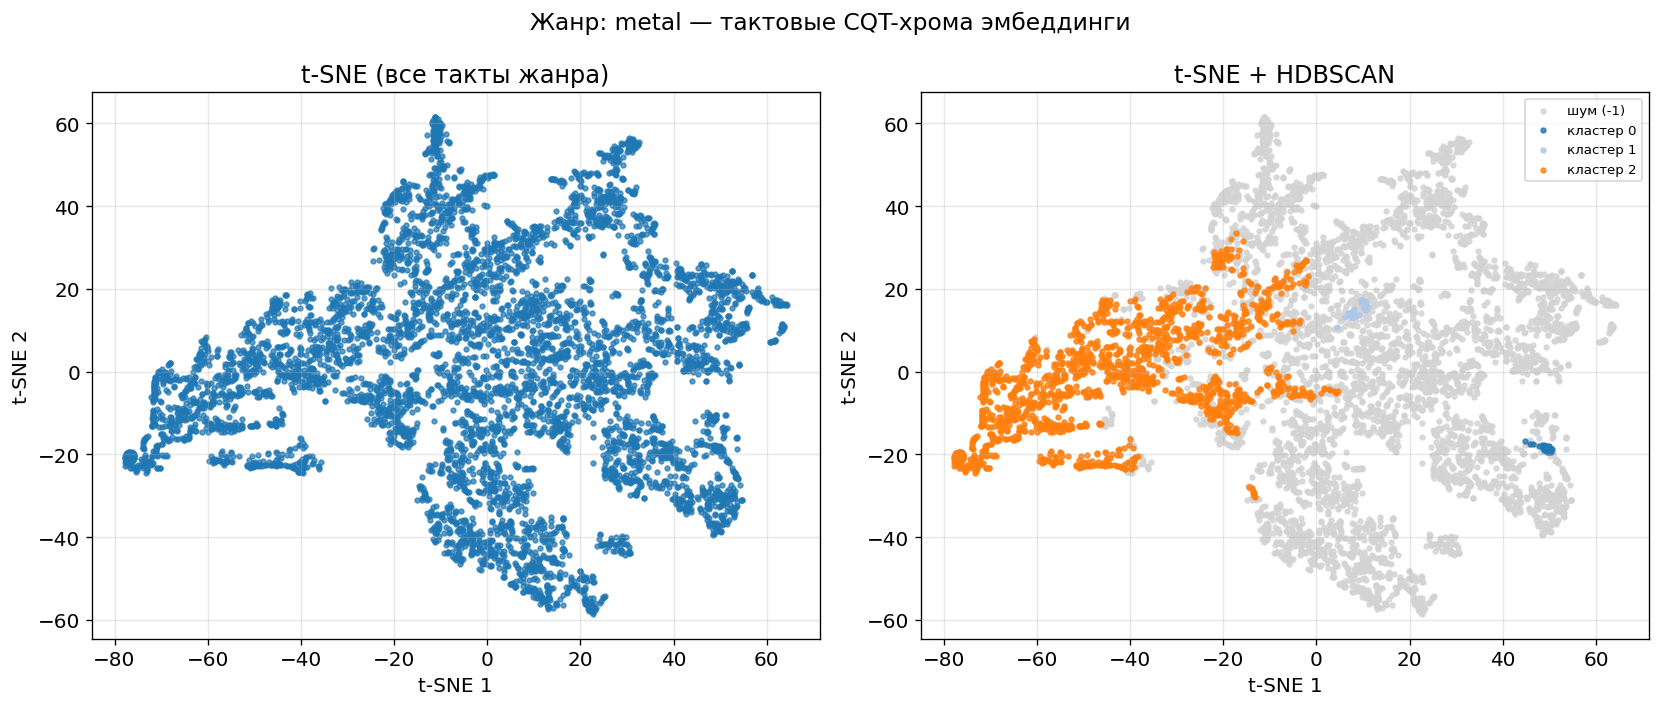

In [20]:
tsne_hdbscan_for_genre(GENRE_PATHS["metal"])


### Pop


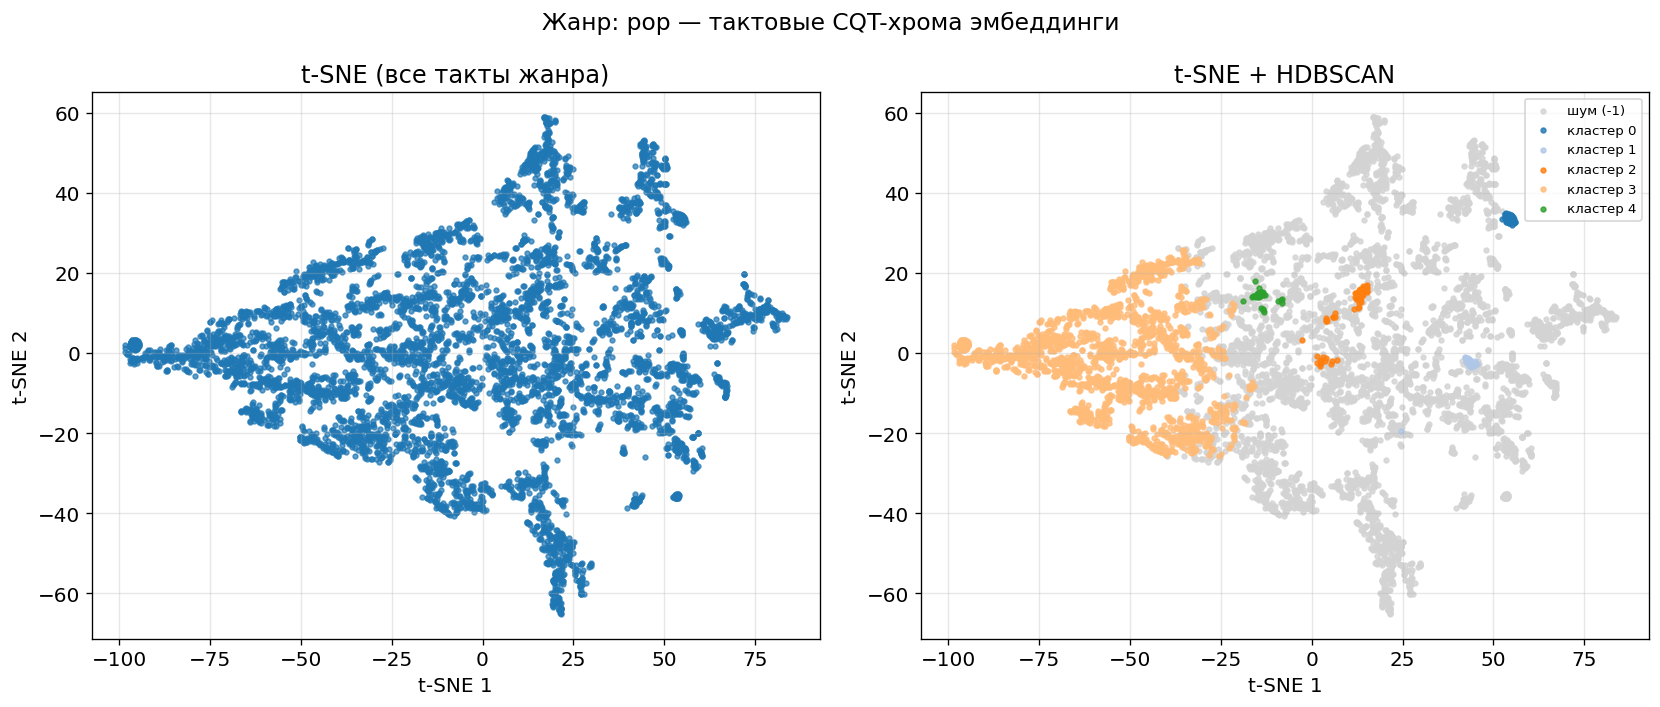

In [21]:
tsne_hdbscan_for_genre(GENRE_PATHS["pop"])


### Reggae


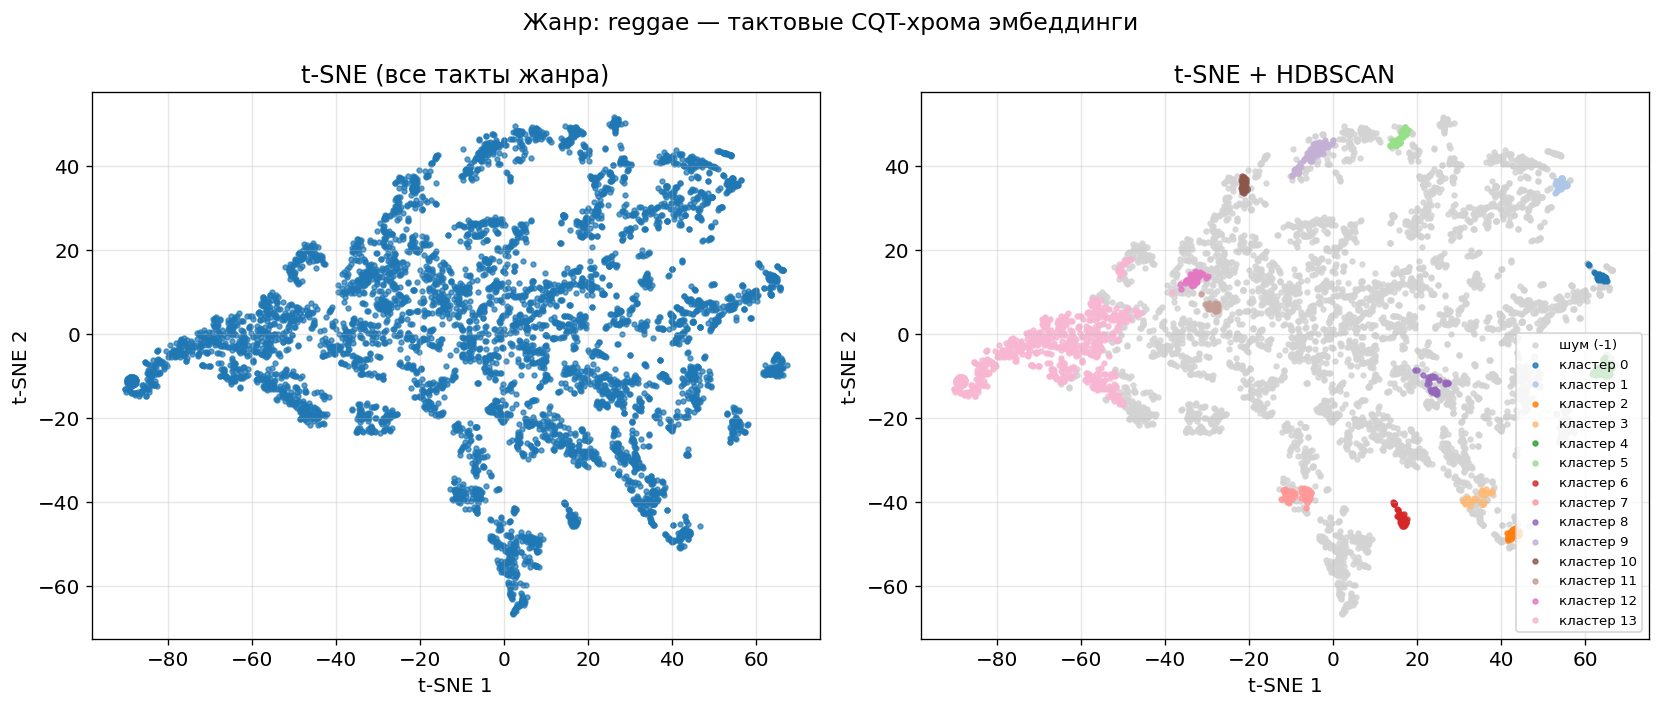

In [22]:
tsne_hdbscan_for_genre(GENRE_PATHS["reggae"])


### Rock


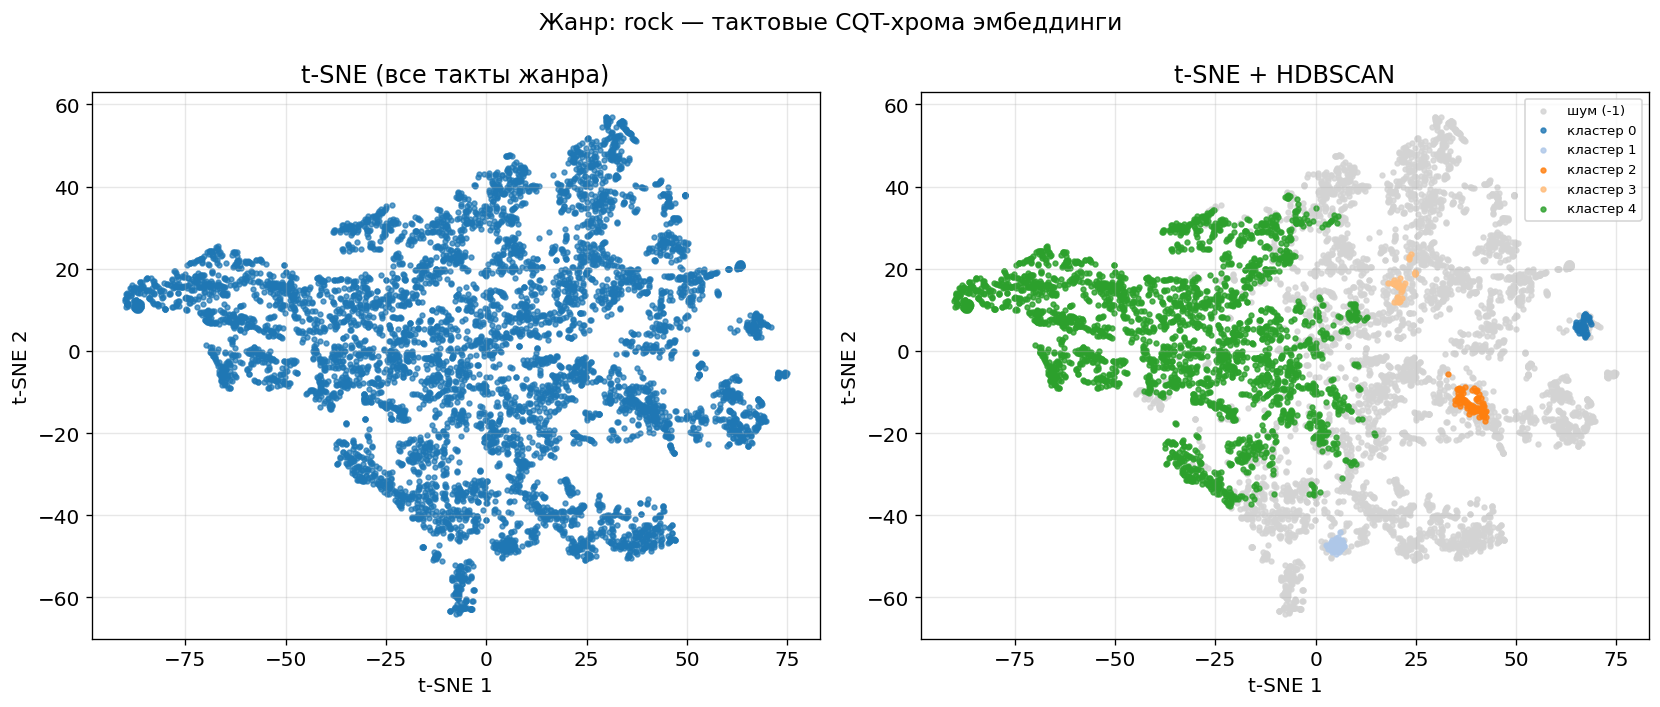

In [23]:
tsne_hdbscan_for_genre(GENRE_PATHS["rock"])


## t-SNE визуализация и кластеризация


In [24]:
# Применяем t-SNE для понижения размерности до 2D
print("Применение t-SNE...")
tsne = TSNE(n_components=2, 
            perplexity=min(tsne_perplexity, n_bars - 1),  # perplexity должно быть < n_samples
            max_iter=tsne_iterations,
            random_state=tsne_random_state,
            verbose=1)

embeddings_2d = tsne.fit_transform(bar_embeddings_norm)
print(f"t-SNE преобразование завершено. Форма: {embeddings_2d.shape}")


Применение t-SNE...


NameError: name 'n_bars' is not defined

In [ ]:
# Кластеризация KMeans
print(f"\nПрименение KMeans кластеризации с {n_clusters} кластерами...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(bar_embeddings_norm)

# Вычисляем коэффициент силуэта для оценки качества кластеризации
silhouette_avg = silhouette_score(bar_embeddings_norm, cluster_labels)
print(f"Средний коэффициент силуэта: {silhouette_avg:.4f}")
print(f"Распределение по кластерам:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Кластер {cluster_id}: {count} тактов ({100*count/n_bars:.1f}%)")



Применение KMeans кластеризации с 5 кластерами...
Средний коэффициент силуэта: 0.4983
Распределение по кластерам:
  Кластер 0: 35 тактов (16.7%)
  Кластер 1: 61 тактов (29.0%)
  Кластер 2: 20 тактов (9.5%)
  Кластер 3: 42 тактов (20.0%)
  Кластер 4: 52 тактов (24.8%)


### Визуализация t-SNE с кластеризацией


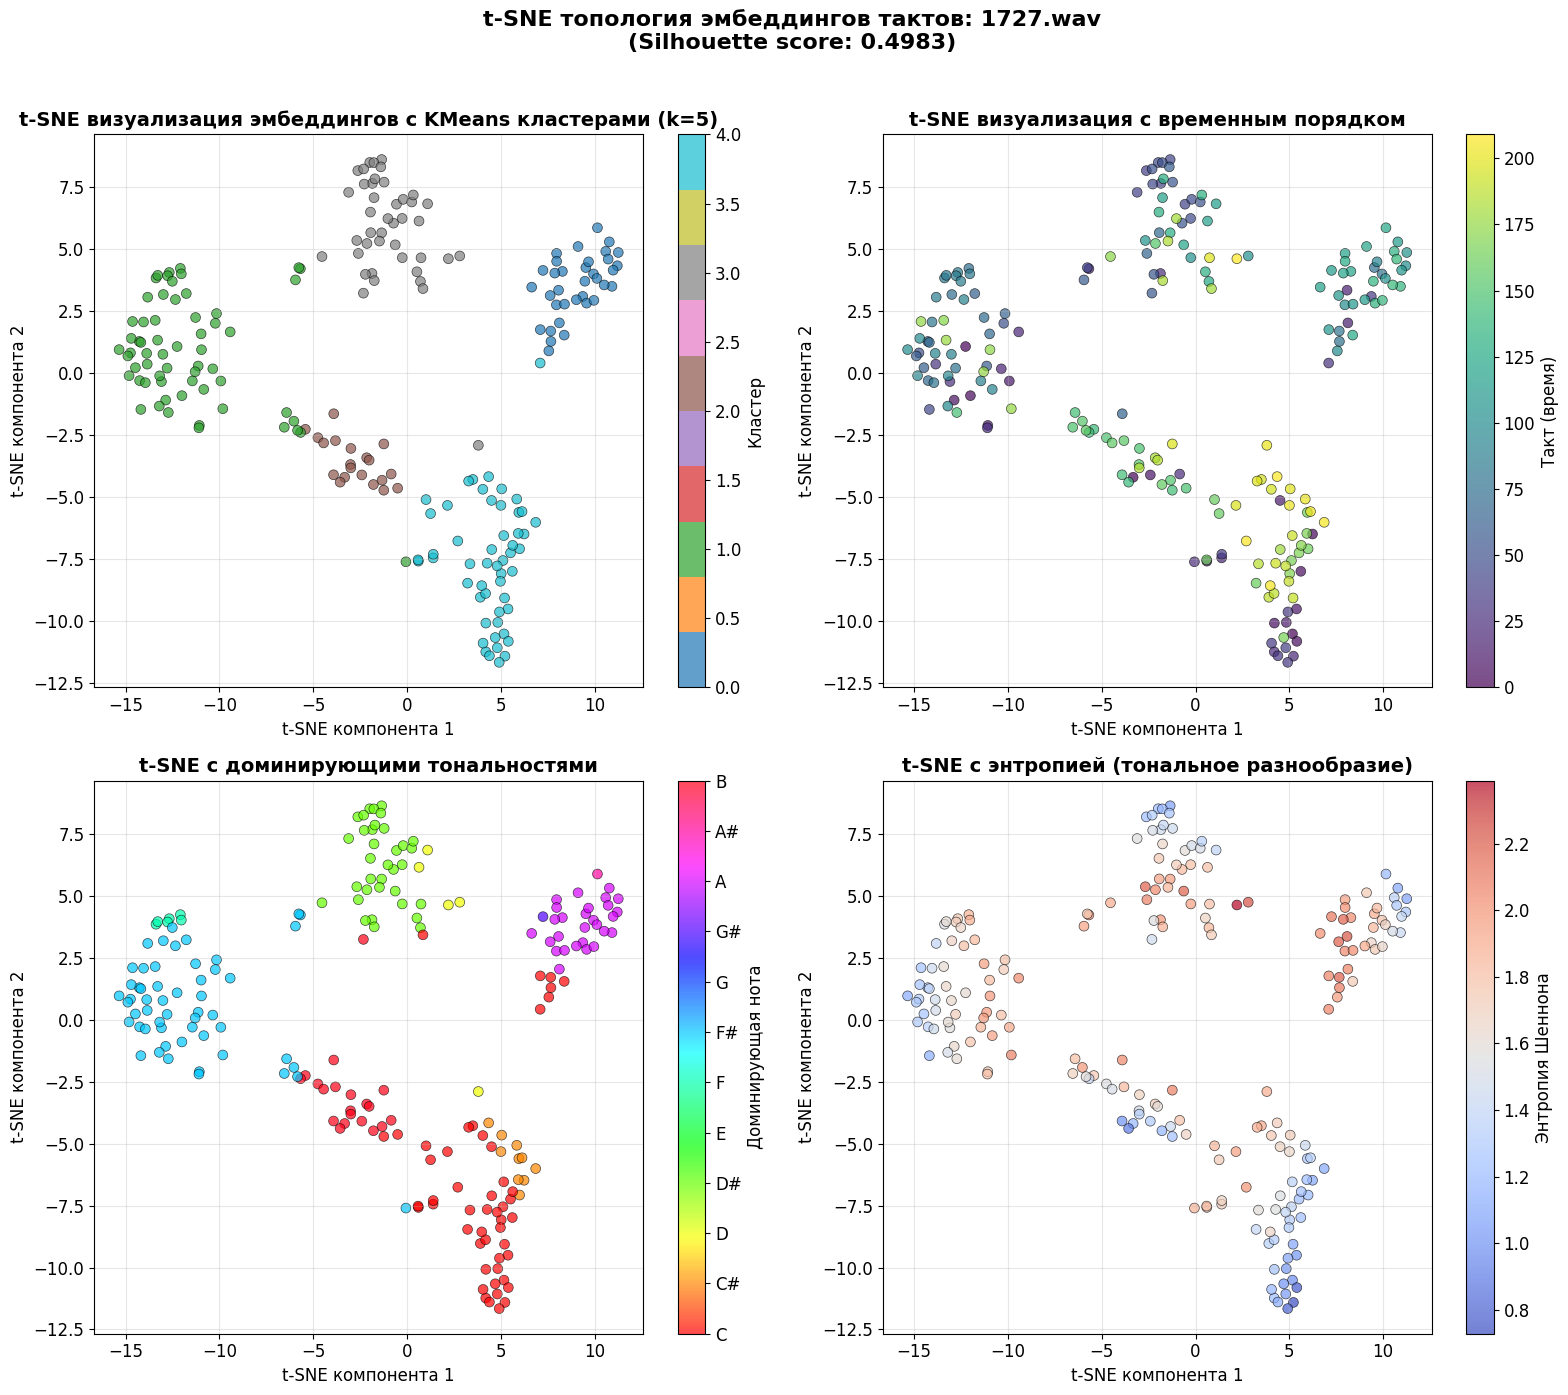

In [ ]:
# Создаём фигуру для t-SNE визуализации
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. t-SNE с кластерами (цвета)
ax1 = axes[0, 0]
scatter = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=cluster_labels, cmap='tab10', 
                      s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('t-SNE компонента 1', fontsize=12)
ax1.set_ylabel('t-SNE компонента 2', fontsize=12)
ax1.set_title(f't-SNE визуализация эмбеддингов с KMeans кластерами (k={n_clusters})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Кластер')

# 2. t-SNE с временным порядком (градиент по времени)
ax2 = axes[0, 1]
scatter2 = ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                       c=bar_indices, cmap='viridis', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('t-SNE компонента 1', fontsize=12)
ax2.set_ylabel('t-SNE компонента 2', fontsize=12)
ax2.set_title('t-SNE визуализация с временным порядком', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Такт (время)')

# 3. t-SNE с доминирующими тональностями
ax3 = axes[1, 0]
dominant_tones = np.argmax(bar_embeddings_norm, axis=1)
scatter3 = ax3.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                       c=dominant_tones, cmap='hsv', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('t-SNE компонента 1', fontsize=12)
ax3.set_ylabel('t-SNE компонента 2', fontsize=12)
ax3.set_title('t-SNE с доминирующими тональностями', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Доминирующая нота')
cbar3.set_ticks(range(12))
cbar3.set_ticklabels(chroma_names)

# 4. t-SNE с энтропией (разнообразие тональности)
ax4 = axes[1, 1]
entropy_per_bar = -np.sum(bar_embeddings_norm * 
                          np.log(bar_embeddings_norm + 1e-9), axis=1)
scatter4 = ax4.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                       c=entropy_per_bar, cmap='coolwarm', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('t-SNE компонента 1', fontsize=12)
ax4.set_ylabel('t-SNE компонента 2', fontsize=12)
ax4.set_title('t-SNE с энтропией (тональное разнообразие)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4, label='Энтропия Шеннона')

fig.suptitle(f't-SNE топология эмбеддингов тактов: {file_name}\n'
             f'(Silhouette score: {silhouette_avg:.4f})', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


### Детальный анализ кластеров


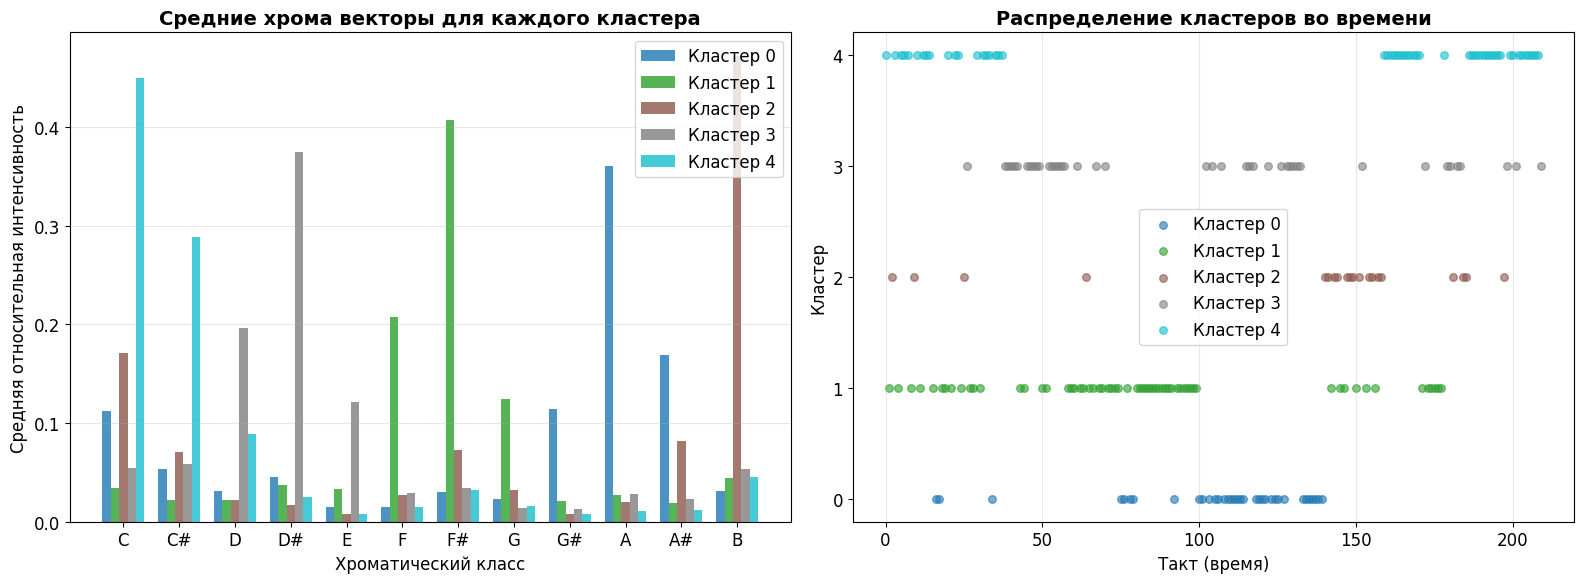


Статистика по кластерам:
------------------------------------------------------------

Кластер 0:
  Количество тактов: 35 (16.7%)
  Временной диапазон: такты 16-139
  Доминирующая тональность: A
  Средняя энтропия: 1.7781

Кластер 1:
  Количество тактов: 61 (29.0%)
  Временной диапазон: такты 1-177
  Доминирующая тональность: F#
  Средняя энтропия: 1.6523

Кластер 2:
  Количество тактов: 20 (9.5%)
  Временной диапазон: такты 2-197
  Доминирующая тональность: B
  Средняя энтропия: 1.5165

Кластер 3:
  Количество тактов: 42 (20.0%)
  Временной диапазон: такты 26-209
  Доминирующая тональность: D#
  Средняя энтропия: 1.6900

Кластер 4:
  Количество тактов: 52 (24.8%)
  Временной диапазон: такты 0-208
  Доминирующая тональность: C
  Средняя энтропия: 1.3991


In [ ]:
# Анализ характеристик каждого кластера
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Средние хрома векторы для каждого кластера
ax1 = axes[0]
cluster_means = []
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

x_pos = np.arange(12)
width = 0.15
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_mean = bar_embeddings_norm[cluster_mask].mean(axis=0)
    cluster_means.append(cluster_mean)
    offset = (cluster_id - n_clusters/2 + 0.5) * width
    ax1.bar(x_pos + offset, cluster_mean, width, 
            label=f'Кластер {cluster_id}', color=cluster_colors[cluster_id], alpha=0.8)

ax1.set_xlabel('Хроматический класс', fontsize=12)
ax1.set_ylabel('Средняя относительная интенсивность', fontsize=12)
ax1.set_title('Средние хрома векторы для каждого кластера', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(chroma_names)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Распределение кластеров по времени
ax2 = axes[1]
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_times = bar_indices[cluster_mask]
    ax2.scatter(cluster_times, np.full(len(cluster_times), cluster_id), 
               color=cluster_colors[cluster_id], label=f'Кластер {cluster_id}',
               s=30, alpha=0.6)

ax2.set_xlabel('Такт (время)', fontsize=12)
ax2.set_ylabel('Кластер', fontsize=12)
ax2.set_title('Распределение кластеров во времени', fontsize=14, fontweight='bold')
ax2.set_yticks(range(n_clusters))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Статистика по кластерам
print("\nСтатистика по кластерам:")
print("-" * 60)
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_bars = bar_indices[cluster_mask]
    cluster_mean_chroma = bar_embeddings_norm[cluster_mask].mean(axis=0)
    dominant_tone_idx = np.argmax(cluster_mean_chroma)
    cluster_entropy = entropy_per_bar[cluster_mask].mean()
    
    print(f"\nКластер {cluster_id}:")
    print(f"  Количество тактов: {np.sum(cluster_mask)} ({100*np.sum(cluster_mask)/n_bars:.1f}%)")
    print(f"  Временной диапазон: такты {cluster_bars.min()}-{cluster_bars.max()}")
    print(f"  Доминирующая тональность: {chroma_names[dominant_tone_idx]}")
    print(f"  Средняя энтропия: {cluster_entropy:.4f}")


## Анализ всех треков из папки classicalLong

Обработка всех файлов с объединением эмбеддингов тактов и анализом топологии через t-SNE


In [ ]:
import glob
from tqdm import tqdm
import time

# Путь к папке с треками
data_folder = "../data/classicalLong"

# Параметры обработки (можно изменить)
bins_per_octave = 36
hop_len = 2048
n_octaves = 7
beats_per_bar = 4
aggregation = 'mean'
use_auto_tempo = True

# Параметры t-SNE и кластеризации для объединенного набора
tsne_perplexity = 50  # Увеличиваем для больших наборов данных
tsne_iterations = 2000
n_clusters_all = 8  # Можно попробовать больше кластеров для разнообразия

# Получаем список всех WAV файлов
wav_files = sorted(glob.glob(os.path.join(data_folder, "*.wav")))
print(f"Найдено {len(wav_files)} WAV файлов для обработки")


Найдено 320 WAV файлов для обработки


In [ ]:
# Обрабатываем все файлы и собираем эмбеддинги
all_embeddings = []
all_metadata = []  # Будет хранить (имя_файла, номер_такта_в_файле, относительное_время)

print("Обработка всех файлов...")
start_time = time.time()

for wav_file in tqdm(wav_files, desc="Обработка файлов"):
    try:
        # Получаем эмбеддинги тактов для текущего файла
        bar_embeddings = cqt_chroma_bar_embeddings(
            file_path=wav_file,
            bins_per_octave=bins_per_octave,
            hop_len=hop_len,
            n_octaves=n_octaves,
            beats_per_bar=beats_per_bar,
            aggregation=aggregation,
            use_auto_tempo=use_auto_tempo,
            bpm=None
        )
        
        # Нормализуем
        bar_embeddings_norm = bar_embeddings / (bar_embeddings.sum(axis=1, keepdims=True) + 1e-9)
        
        # Сохраняем эмбеддинги
        all_embeddings.append(bar_embeddings_norm)
        
        # Сохраняем метаданные: имя файла, номер такта, относительное время
        file_name = os.path.basename(wav_file)
        n_bars_in_file = bar_embeddings_norm.shape[0]
        for bar_idx in range(n_bars_in_file):
            relative_time = bar_idx / n_bars_in_file if n_bars_in_file > 0 else 0.0
            all_metadata.append({
                'file_name': file_name,
                'bar_idx': bar_idx,
                'relative_time': relative_time
            })
    
    except Exception as e:
        print(f"\\nОшибка при обработке {wav_file}: {e}")
        continue

# Объединяем все эмбеддинги в одну матрицу
combined_embeddings = np.vstack(all_embeddings)
n_total_bars = combined_embeddings.shape[0]

elapsed_time = time.time() - start_time
print(f"\\nОбработка завершена!")
print(f"Обработано файлов: {len(all_embeddings)}")
print(f"Всего тактов: {n_total_bars}")
print(f"Время обработки: {elapsed_time/60:.2f} минут ({elapsed_time:.1f} секунд)")
print(f"Форма объединенной матрицы эмбеддингов: {combined_embeddings.shape}")


Обработка всех файлов...


Обработка файлов: 100%|██████████| 320/320 [08:29<00:00,  1.59s/it]

\nОбработка завершена!
Обработано файлов: 320
Всего тактов: 65331
Время обработки: 8.50 минут (509.8 секунд)
Форма объединенной матрицы эмбеддингов: (65331, 12)


In [ ]:
# Создаем массивы для удобной работы с метаданными
file_names = np.array([m['file_name'] for m in all_metadata])
bar_indices = np.array([m['bar_idx'] for m in all_metadata])
relative_times = np.array([m['relative_time'] for m in all_metadata])

# Получаем уникальные имена файлов и создаем числовой массив для цветовой маркировки
unique_files = np.unique(file_names)
file_to_id = {fname: idx for idx, fname in enumerate(unique_files)}
file_ids = np.array([file_to_id[fname] for fname in file_names])

print(f"Уникальных файлов: {len(unique_files)}")
if all_embeddings:
    bars_per_file = [emb.shape[0] for emb in all_embeddings]
    print(f"Тактов на файл: в среднем {np.mean(bars_per_file):.1f}, "
          f"минимум {min(bars_per_file)}, "
          f"максимум {max(bars_per_file)}")
else:
    print("Нет обработанных файлов")


Уникальных файлов: 320
Тактов на файл: в среднем 204.2, минимум 22, максимум 682


### Применение t-SNE к объединенному набору данных


In [ ]:
# Применяем t-SNE
print("Применение t-SNE к объединенному набору данных...")
print(f"Размерность данных: {combined_embeddings.shape}")
print(f"Perplexity: {min(tsne_perplexity, n_total_bars - 1)}")

tsne_start = time.time()
tsne_all = TSNE(n_components=2, 
                perplexity=min(tsne_perplexity, n_total_bars - 1),
                max_iter=tsne_iterations,
                random_state=42,
                verbose=1)

embeddings_2d_all = tsne_all.fit_transform(combined_embeddings)
tsne_elapsed = time.time() - tsne_start

print(f"\\nt-SNE завершен за {tsne_elapsed/60:.2f} минут ({tsne_elapsed:.1f} секунд)")
print(f"Форма 2D представления: {embeddings_2d_all.shape}")


Применение t-SNE к объединенному набору данных...
Размерность данных: (65331, 12)
Perplexity: 50
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 65331 samples in 0.024s...
[t-SNE] Computed neighbors for 65331 samples in 5.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 65331
[t-SNE] Computed conditional probabilities for sample 2000 / 65331
[t-SNE] Computed conditional probabilities for sample 3000 / 65331
[t-SNE] Computed conditional probabilities for sample 4000 / 65331
[t-SNE] Computed conditional probabilities for sample 5000 / 65331
[t-SNE] Computed conditional probabilities for sample 6000 / 65331
[t-SNE] Computed conditional probabilities for sample 7000 / 65331
[t-SNE] Computed conditional probabilities for sample 8000 / 65331
[t-SNE] Computed conditional probabilities for sample 9000 / 65331
[t-SNE] Computed conditional probabilities for sample 10000 / 65331
[t-SNE] Computed conditional probabilities for sample 11000 / 65331
[t-SNE] Computed con

In [ ]:
# Кластеризация объединенного набора данных
print(f"\\nПрименение KMeans кластеризации с {n_clusters_all} кластерами...")
kmeans_all = KMeans(n_clusters=n_clusters_all, random_state=42, n_init=10, verbose=0)
cluster_labels_all = kmeans_all.fit_predict(combined_embeddings)

# Коэффициент силуэта
silhouette_avg_all = silhouette_score(combined_embeddings, cluster_labels_all)
print(f"Средний коэффициент силуэта: {silhouette_avg_all:.4f}")

# Распределение по кластерам
unique_clusters, cluster_counts = np.unique(cluster_labels_all, return_counts=True)
print(f"Распределение по кластерам:")
for cluster_id, count in zip(unique_clusters, cluster_counts):
    print(f"  Кластер {cluster_id}: {count} тактов ({100*count/n_total_bars:.1f}%)")


\nПрименение KMeans кластеризации с 8 кластерами...
Средний коэффициент силуэта: 0.2827
Распределение по кластерам:
  Кластер 0: 9934 тактов (15.2%)
  Кластер 1: 8827 тактов (13.5%)
  Кластер 2: 4588 тактов (7.0%)
  Кластер 3: 9732 тактов (14.9%)
  Кластер 4: 2938 тактов (4.5%)
  Кластер 5: 11444 тактов (17.5%)
  Кластер 6: 6432 тактов (9.8%)
  Кластер 7: 11436 тактов (17.5%)


### Визуализация t-SNE для всех треков


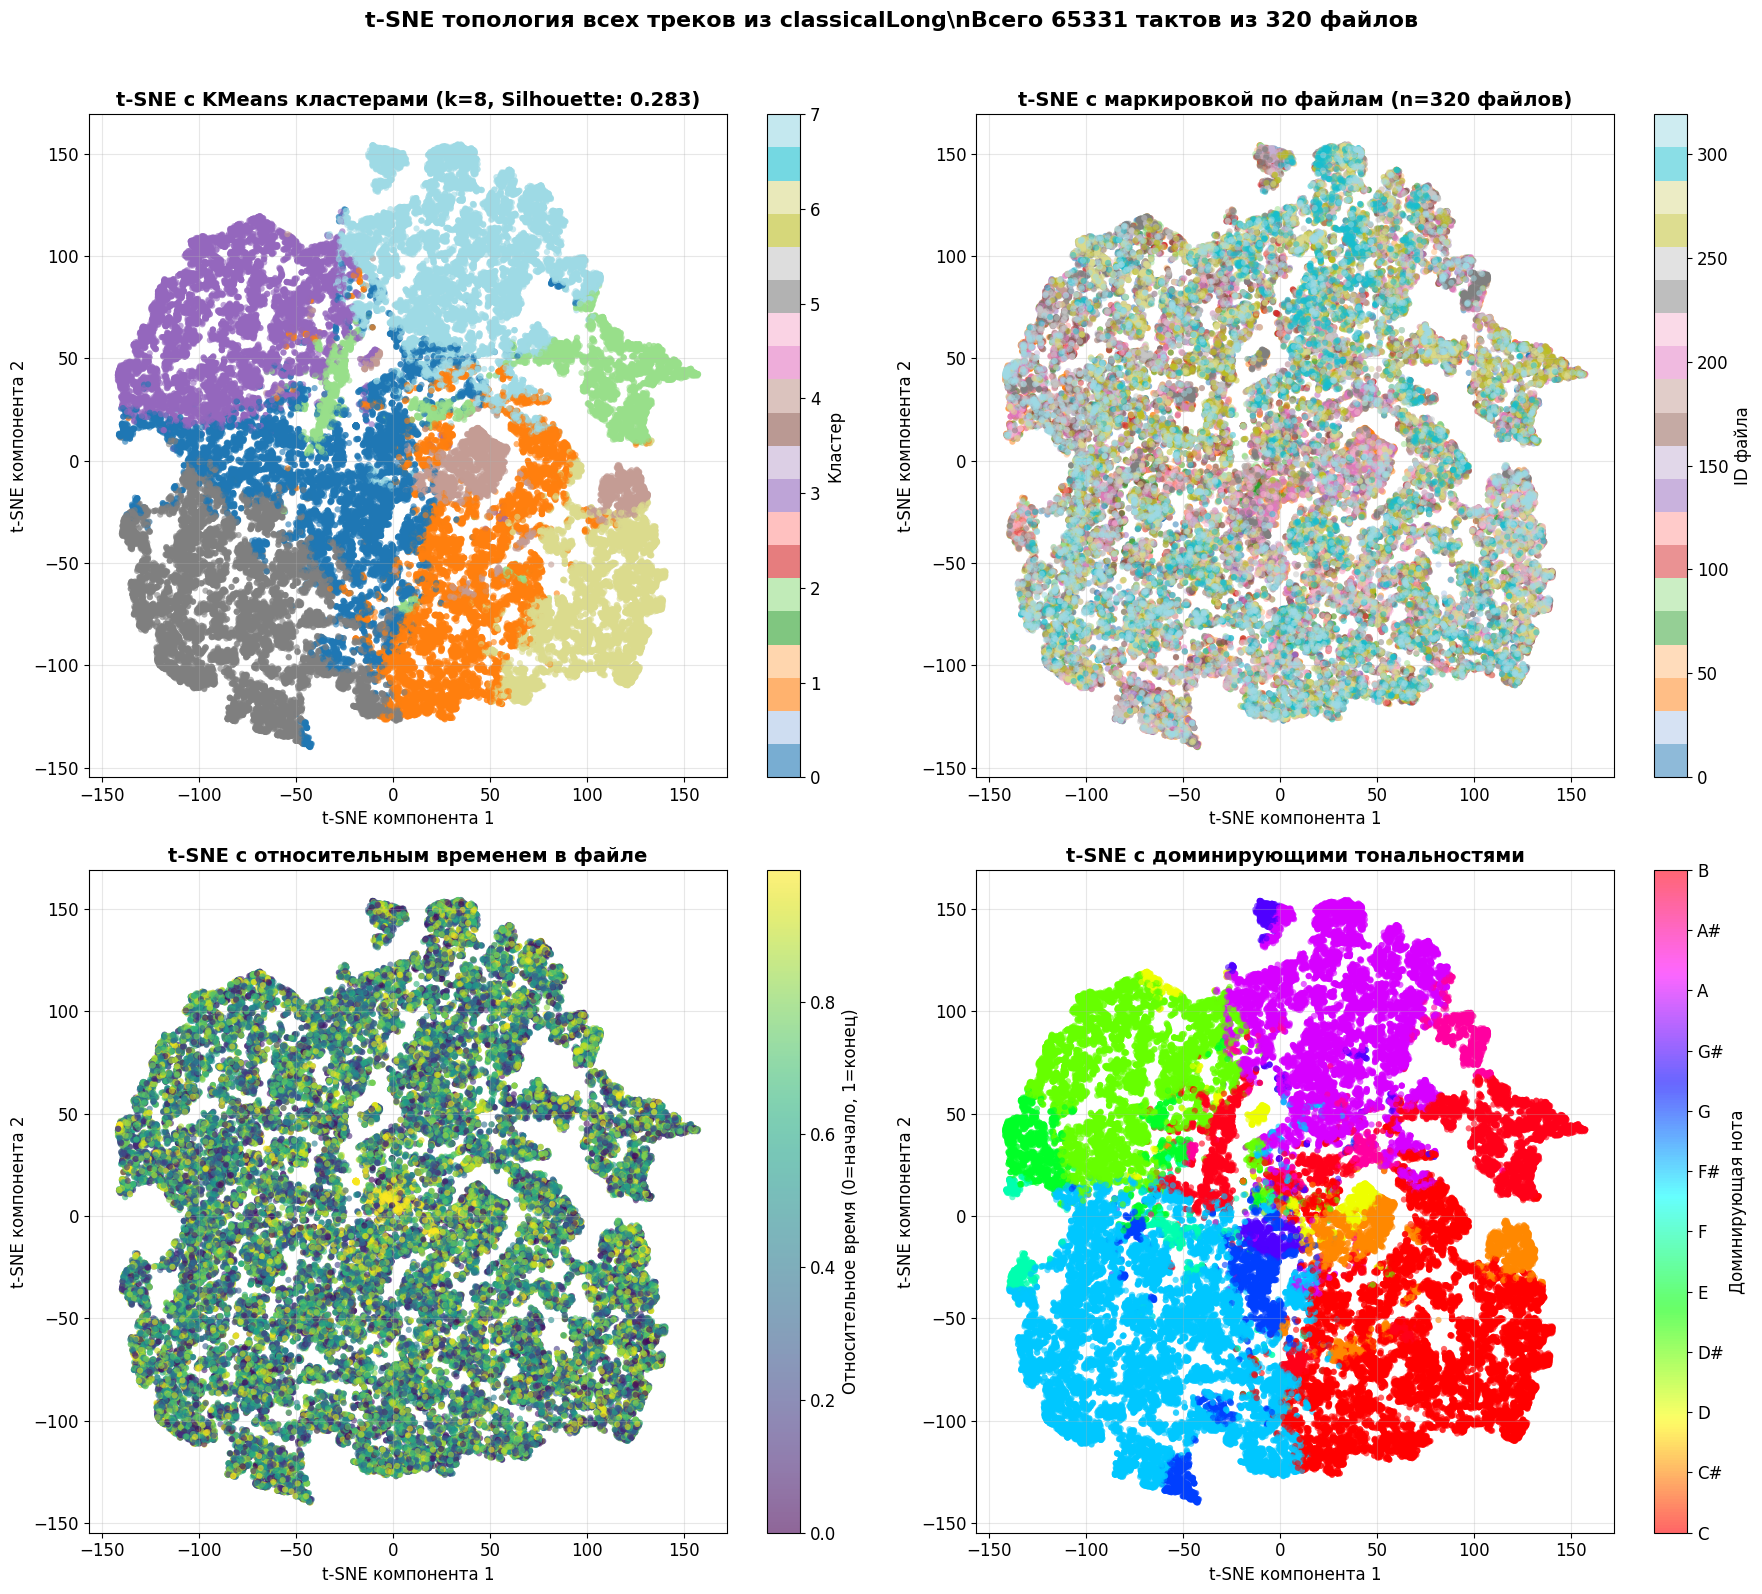

In [ ]:
# Создаём большую фигуру для визуализации
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 1. t-SNE с кластерами
ax1 = axes[0, 0]
scatter1 = ax1.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=cluster_labels_all, cmap='tab20', 
                       s=20, alpha=0.6, edgecolors='none')
ax1.set_xlabel('t-SNE компонента 1', fontsize=12)
ax1.set_ylabel('t-SNE компонента 2', fontsize=12)
ax1.set_title(f't-SNE с KMeans кластерами (k={n_clusters_all}, Silhouette: {silhouette_avg_all:.3f})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Кластер')

# 2. t-SNE с файлами (цвет по файлу)
ax2 = axes[0, 1]
# Используем циклическую палитру для большего количества файлов
n_files = len(unique_files)
colors_file = plt.cm.tab20(np.linspace(0, 1, min(20, n_files)))
if n_files > 20:
    # Для больше 20 файлов используем HSV
    colors_file = plt.cm.hsv(np.linspace(0, 1, n_files))

file_colors_map = colors_file[file_ids % len(colors_file)]
scatter2 = ax2.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=file_ids, cmap='tab20', 
                       s=20, alpha=0.5, edgecolors='none')
ax2.set_xlabel('t-SNE компонента 1', fontsize=12)
ax2.set_ylabel('t-SNE компонента 2', fontsize=12)
ax2.set_title(f't-SNE с маркировкой по файлам (n={n_files} файлов)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='ID файла')

# 3. t-SNE с относительным временем в файле
ax3 = axes[1, 0]
scatter3 = ax3.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=relative_times, cmap='viridis', 
                       s=20, alpha=0.6, edgecolors='none')
ax3.set_xlabel('t-SNE компонента 1', fontsize=12)
ax3.set_ylabel('t-SNE компонента 2', fontsize=12)
ax3.set_title('t-SNE с относительным временем в файле', 
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Относительное время (0=начало, 1=конец)')

# 4. t-SNE с доминирующими тональностями
ax4 = axes[1, 1]
dominant_tones_all = np.argmax(combined_embeddings, axis=1)
scatter4 = ax4.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=dominant_tones_all, cmap='hsv', 
                       s=20, alpha=0.6, edgecolors='none')
ax4.set_xlabel('t-SNE компонента 1', fontsize=12)
ax4.set_ylabel('t-SNE компонента 2', fontsize=12)
ax4.set_title('t-SNE с доминирующими тональностями', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Доминирующая нота')
cbar4.set_ticks(range(12))
cbar4.set_ticklabels(chroma_names)

fig.suptitle(f't-SNE топология всех треков из classicalLong\\n'
             f'Всего {n_total_bars} тактов из {n_files} файлов', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


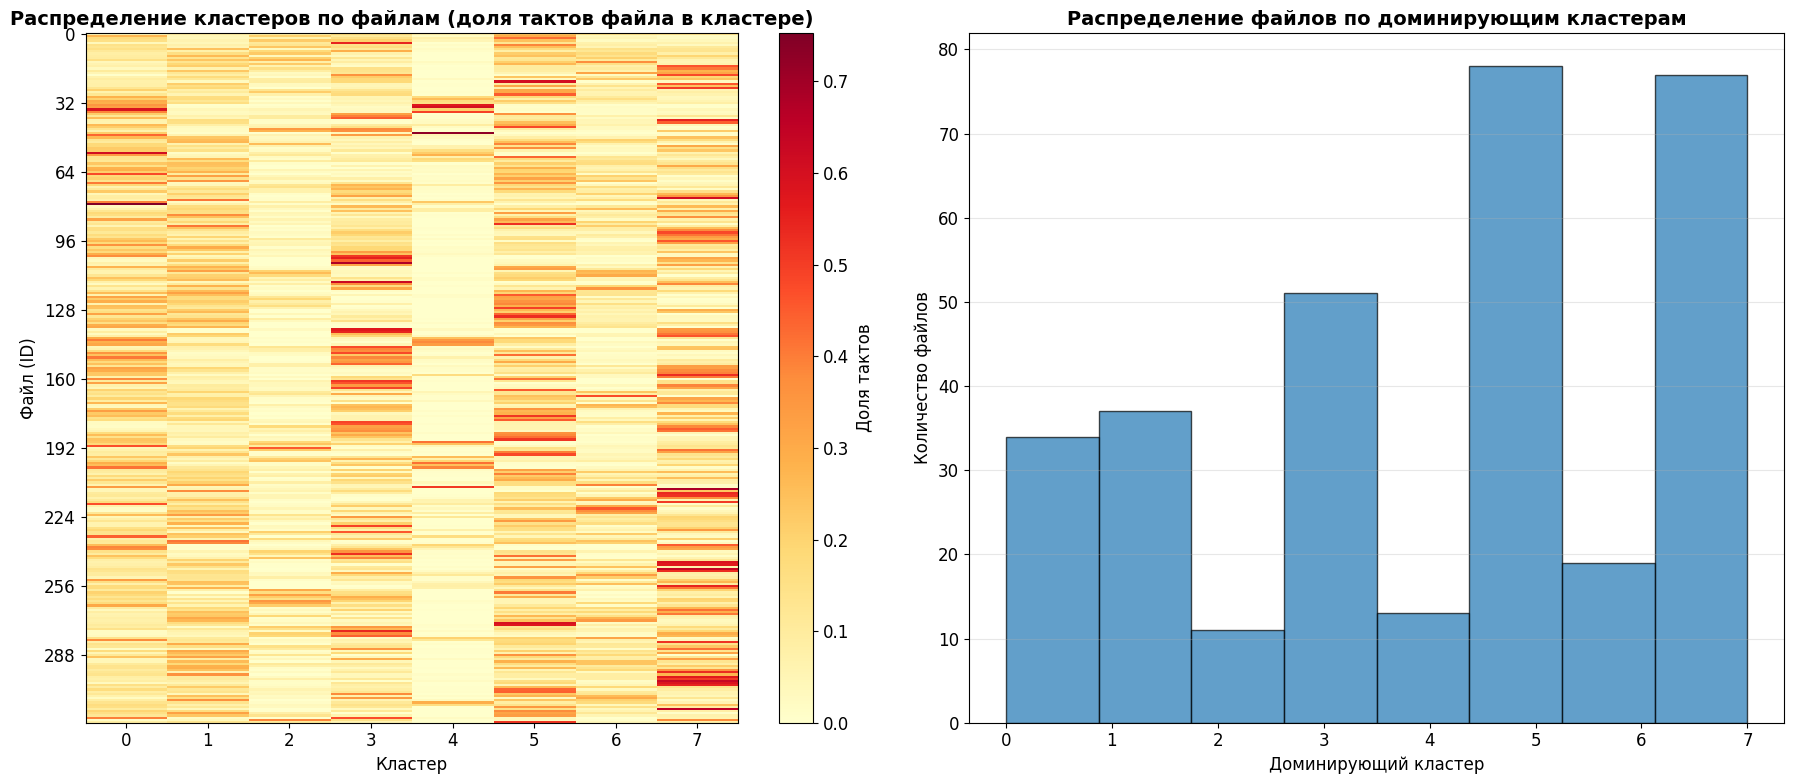

\nДетальная статистика по кластерам:
\nКластер 0:
  Всего тактов: 9934 (15.2%)
  Файлов содержит: 320 (100.0% всех файлов)
  Средняя доля в файлах: 0.161
  Доминирующая тональность: F#
  Средняя энтропия: 2.3748
\nКластер 1:
  Всего тактов: 8827 (13.5%)
  Файлов содержит: 317 (99.1% всех файлов)
  Средняя доля в файлах: 0.140
  Доминирующая тональность: C
  Средняя энтропия: 2.2184
\nКластер 2:
  Всего тактов: 4588 (7.0%)
  Файлов содержит: 272 (85.0% всех файлов)
  Средняя доля в файлах: 0.063
  Доминирующая тональность: B
  Средняя энтропия: 1.9523
\nКластер 3:
  Всего тактов: 9732 (14.9%)
  Файлов содержит: 301 (94.1% всех файлов)
  Средняя доля в файлах: 0.151
  Доминирующая тональность: D#
  Средняя энтропия: 2.0224
\nКластер 4:
  Всего тактов: 2938 (4.5%)
  Файлов содержит: 195 (60.9% всех файлов)
  Средняя доля в файлах: 0.043
  Доминирующая тональность: C#
  Средняя энтропия: 2.0091
\nКластер 5:
  Всего тактов: 11444 (17.5%)
  Файлов содержит: 305 (95.3% всех файлов)
  Средняя 

In [ ]:
# Анализ: какие файлы попадают в какие кластеры
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Матрица: файл x кластер (процент тактов каждого файла в каждом кластере)
ax1 = axes[0]
cluster_distribution = np.zeros((len(unique_files), n_clusters_all))
for i, file_name in enumerate(unique_files):
    file_mask = file_names == file_name
    for cluster_id in range(n_clusters_all):
        cluster_mask = cluster_labels_all == cluster_id
        count = np.sum(file_mask & cluster_mask)
        total_bars_in_file = np.sum(file_mask)
        cluster_distribution[i, cluster_id] = count / total_bars_in_file if total_bars_in_file > 0 else 0

im = ax1.imshow(cluster_distribution, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax1.set_xlabel('Кластер', fontsize=12)
ax1.set_ylabel('Файл (ID)', fontsize=12)
ax1.set_title('Распределение кластеров по файлам (доля тактов файла в кластере)', 
              fontsize=14, fontweight='bold')
ax1.set_yticks(range(0, len(unique_files), max(1, len(unique_files)//10)))
ax1.set_xticks(range(n_clusters_all))
plt.colorbar(im, ax=ax1, label='Доля тактов')

# 2. Гистограмма количества файлов с доминирующим кластером
ax2 = axes[1]
dominant_cluster_per_file = []
for file_name in unique_files:
    file_mask = file_names == file_name
    file_clusters = cluster_labels_all[file_mask]
    if len(file_clusters) > 0:
        unique_file_clusters, counts = np.unique(file_clusters, return_counts=True)
        dominant_cluster = unique_file_clusters[np.argmax(counts)]
        dominant_cluster_per_file.append(dominant_cluster)

ax2.hist(dominant_cluster_per_file, bins=n_clusters_all, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Доминирующий кластер', fontsize=12)
ax2.set_ylabel('Количество файлов', fontsize=12)
ax2.set_title('Распределение файлов по доминирующим кластерам', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(range(n_clusters_all))
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Статистика по кластерам для всех файлов
print("\\nДетальная статистика по кластерам:")
print("=" * 80)
for cluster_id in range(n_clusters_all):
    cluster_mask = cluster_labels_all == cluster_id
    cluster_files = np.unique(file_names[cluster_mask])
    cluster_files_percent = 100 * len(cluster_files) / len(unique_files)
    
    print(f"\\nКластер {cluster_id}:")
    print(f"  Всего тактов: {np.sum(cluster_mask)} ({100*np.sum(cluster_mask)/n_total_bars:.1f}%)")
    print(f"  Файлов содержит: {len(cluster_files)} ({cluster_files_percent:.1f}% всех файлов)")
    print(f"  Средняя доля в файлах: {np.mean(cluster_distribution[:, cluster_id]):.3f}")
    
    # Доминирующая тональность в кластере
    cluster_embeddings = combined_embeddings[cluster_mask]
    cluster_mean = cluster_embeddings.mean(axis=0)
    dominant_tone_idx = np.argmax(cluster_mean)
    print(f"  Доминирующая тональность: {chroma_names[dominant_tone_idx]}")
    
    # Энтропия
    cluster_mean_norm = cluster_mean / (cluster_mean.sum() + 1e-9)
    cluster_entropy = -np.sum(cluster_mean_norm * np.log(cluster_mean_norm + 1e-9))
    print(f"  Средняя энтропия: {cluster_entropy:.4f}")


## Анализ всех треков из папки Jazz

Обработка всех файлов с объединением эмбеддингов тактов и анализом топологии через t-SNE


In [ ]:
import glob
from tqdm import tqdm
import time

# Путь к папке с треками
data_folder = "../data/genres_30sec/pop"

# Параметры обработки (можно изменить)
bins_per_octave = 36
hop_len = 2048
n_octaves = 7
beats_per_bar = 4
aggregation = 'mean'
use_auto_tempo = True

# Параметры t-SNE и кластеризации для объединенного набора
tsne_perplexity = 50  # Увеличиваем для больших наборов данных
tsne_iterations = 2000
n_clusters_all = 8  # Можно попробовать больше кластеров для разнообразия

# Получаем список всех WAV файлов
wav_files = sorted(glob.glob(os.path.join(data_folder, "*.wav")))
print(f"Найдено {len(wav_files)} WAV файлов для обработки")


Найдено 100 WAV файлов для обработки


In [ ]:
# Обрабатываем все файлы и собираем эмбеддинги
all_embeddings = []
all_metadata = []  # Будет хранить (имя_файла, номер_такта_в_файле, относительное_время)

print("Обработка всех файлов...")
start_time = time.time()

for wav_file in tqdm(wav_files, desc="Обработка файлов"):
    try:
        # Получаем эмбеддинги тактов для текущего файла
        bar_embeddings = cqt_chroma_bar_embeddings(
            file_path=wav_file,
            bins_per_octave=bins_per_octave,
            hop_len=hop_len,
            n_octaves=n_octaves,
            beats_per_bar=beats_per_bar,
            aggregation=aggregation,
            use_auto_tempo=use_auto_tempo,
            bpm=None
        )
        
        # Нормализуем
        bar_embeddings_norm = bar_embeddings / (bar_embeddings.sum(axis=1, keepdims=True) + 1e-9)
        
        # Сохраняем эмбеддинги
        all_embeddings.append(bar_embeddings_norm)
        
        # Сохраняем метаданные: имя файла, номер такта, относительное время
        file_name = os.path.basename(wav_file)
        n_bars_in_file = bar_embeddings_norm.shape[0]
        for bar_idx in range(n_bars_in_file):
            relative_time = bar_idx / n_bars_in_file if n_bars_in_file > 0 else 0.0
            all_metadata.append({
                'file_name': file_name,
                'bar_idx': bar_idx,
                'relative_time': relative_time
            })
    
    except Exception as e:
        print(f"\\nОшибка при обработке {wav_file}: {e}")
        continue

# Объединяем все эмбеддинги в одну матрицу
combined_embeddings = np.vstack(all_embeddings)
n_total_bars = combined_embeddings.shape[0]

elapsed_time = time.time() - start_time
print(f"\\nОбработка завершена!")
print(f"Обработано файлов: {len(all_embeddings)}")
print(f"Всего тактов: {n_total_bars}")
print(f"Время обработки: {elapsed_time/60:.2f} минут ({elapsed_time:.1f} секунд)")
print(f"Форма объединенной матрицы эмбеддингов: {combined_embeddings.shape}")


Обработка всех файлов...


Обработка файлов: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]

\nОбработка завершена!
Обработано файлов: 100
Всего тактов: 1439
Время обработки: 0.23 минут (13.9 секунд)
Форма объединенной матрицы эмбеддингов: (1439, 12)


In [ ]:
# Создаем массивы для удобной работы с метаданными
file_names = np.array([m['file_name'] for m in all_metadata])
bar_indices = np.array([m['bar_idx'] for m in all_metadata])
relative_times = np.array([m['relative_time'] for m in all_metadata])

# Получаем уникальные имена файлов и создаем числовой массив для цветовой маркировки
unique_files = np.unique(file_names)
file_to_id = {fname: idx for idx, fname in enumerate(unique_files)}
file_ids = np.array([file_to_id[fname] for fname in file_names])

print(f"Уникальных файлов: {len(unique_files)}")
if all_embeddings:
    bars_per_file = [emb.shape[0] for emb in all_embeddings]
    print(f"Тактов на файл: в среднем {np.mean(bars_per_file):.1f}, "
          f"минимум {min(bars_per_file)}, "
          f"максимум {max(bars_per_file)}")
else:
    print("Нет обработанных файлов")


Уникальных файлов: 100
Тактов на файл: в среднем 14.4, минимум 8, максимум 27


### Применение t-SNE к объединенному набору данных


In [ ]:
# Применяем t-SNE
print("Применение t-SNE к объединенному набору данных...")
print(f"Размерность данных: {combined_embeddings.shape}")
print(f"Perplexity: {min(tsne_perplexity, n_total_bars - 1)}")

tsne_start = time.time()
tsne_all = TSNE(n_components=2, 
                perplexity=min(tsne_perplexity, n_total_bars - 1),
                max_iter=tsne_iterations,
                random_state=42,
                verbose=1)

embeddings_2d_all = tsne_all.fit_transform(combined_embeddings)
tsne_elapsed = time.time() - tsne_start

print(f"\\nt-SNE завершен за {tsne_elapsed/60:.2f} минут ({tsne_elapsed:.1f} секунд)")
print(f"Форма 2D представления: {embeddings_2d_all.shape}")


Применение t-SNE к объединенному набору данных...
Размерность данных: (1439, 12)
Perplexity: 50
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1439 samples in 0.001s...
[t-SNE] Computed neighbors for 1439 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1439
[t-SNE] Computed conditional probabilities for sample 1439 / 1439
[t-SNE] Mean sigma: 0.045515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.239723
[t-SNE] KL divergence after 2000 iterations: 0.815479
\nt-SNE завершен за 0.11 минут (6.7 секунд)
Форма 2D представления: (1439, 2)


In [ ]:
# Кластеризация объединенного набора данных
print(f"\\nПрименение KMeans кластеризации с {n_clusters_all} кластерами...")
kmeans_all = KMeans(n_clusters=n_clusters_all, random_state=42, n_init=10, verbose=0)
cluster_labels_all = kmeans_all.fit_predict(combined_embeddings)

# Коэффициент силуэта
silhouette_avg_all = silhouette_score(combined_embeddings, cluster_labels_all)
print(f"Средний коэффициент силуэта: {silhouette_avg_all:.4f}")

# Распределение по кластерам
unique_clusters, cluster_counts = np.unique(cluster_labels_all, return_counts=True)
print(f"Распределение по кластерам:")
for cluster_id, count in zip(unique_clusters, cluster_counts):
    print(f"  Кластер {cluster_id}: {count} тактов ({100*count/n_total_bars:.1f}%)")


\nПрименение KMeans кластеризации с 8 кластерами...
Средний коэффициент силуэта: 0.2414
Распределение по кластерам:
  Кластер 0: 532 тактов (37.0%)
  Кластер 1: 154 тактов (10.7%)
  Кластер 2: 209 тактов (14.5%)
  Кластер 3: 79 тактов (5.5%)
  Кластер 4: 132 тактов (9.2%)
  Кластер 5: 42 тактов (2.9%)
  Кластер 6: 55 тактов (3.8%)
  Кластер 7: 236 тактов (16.4%)


### Визуализация t-SNE для всех треков


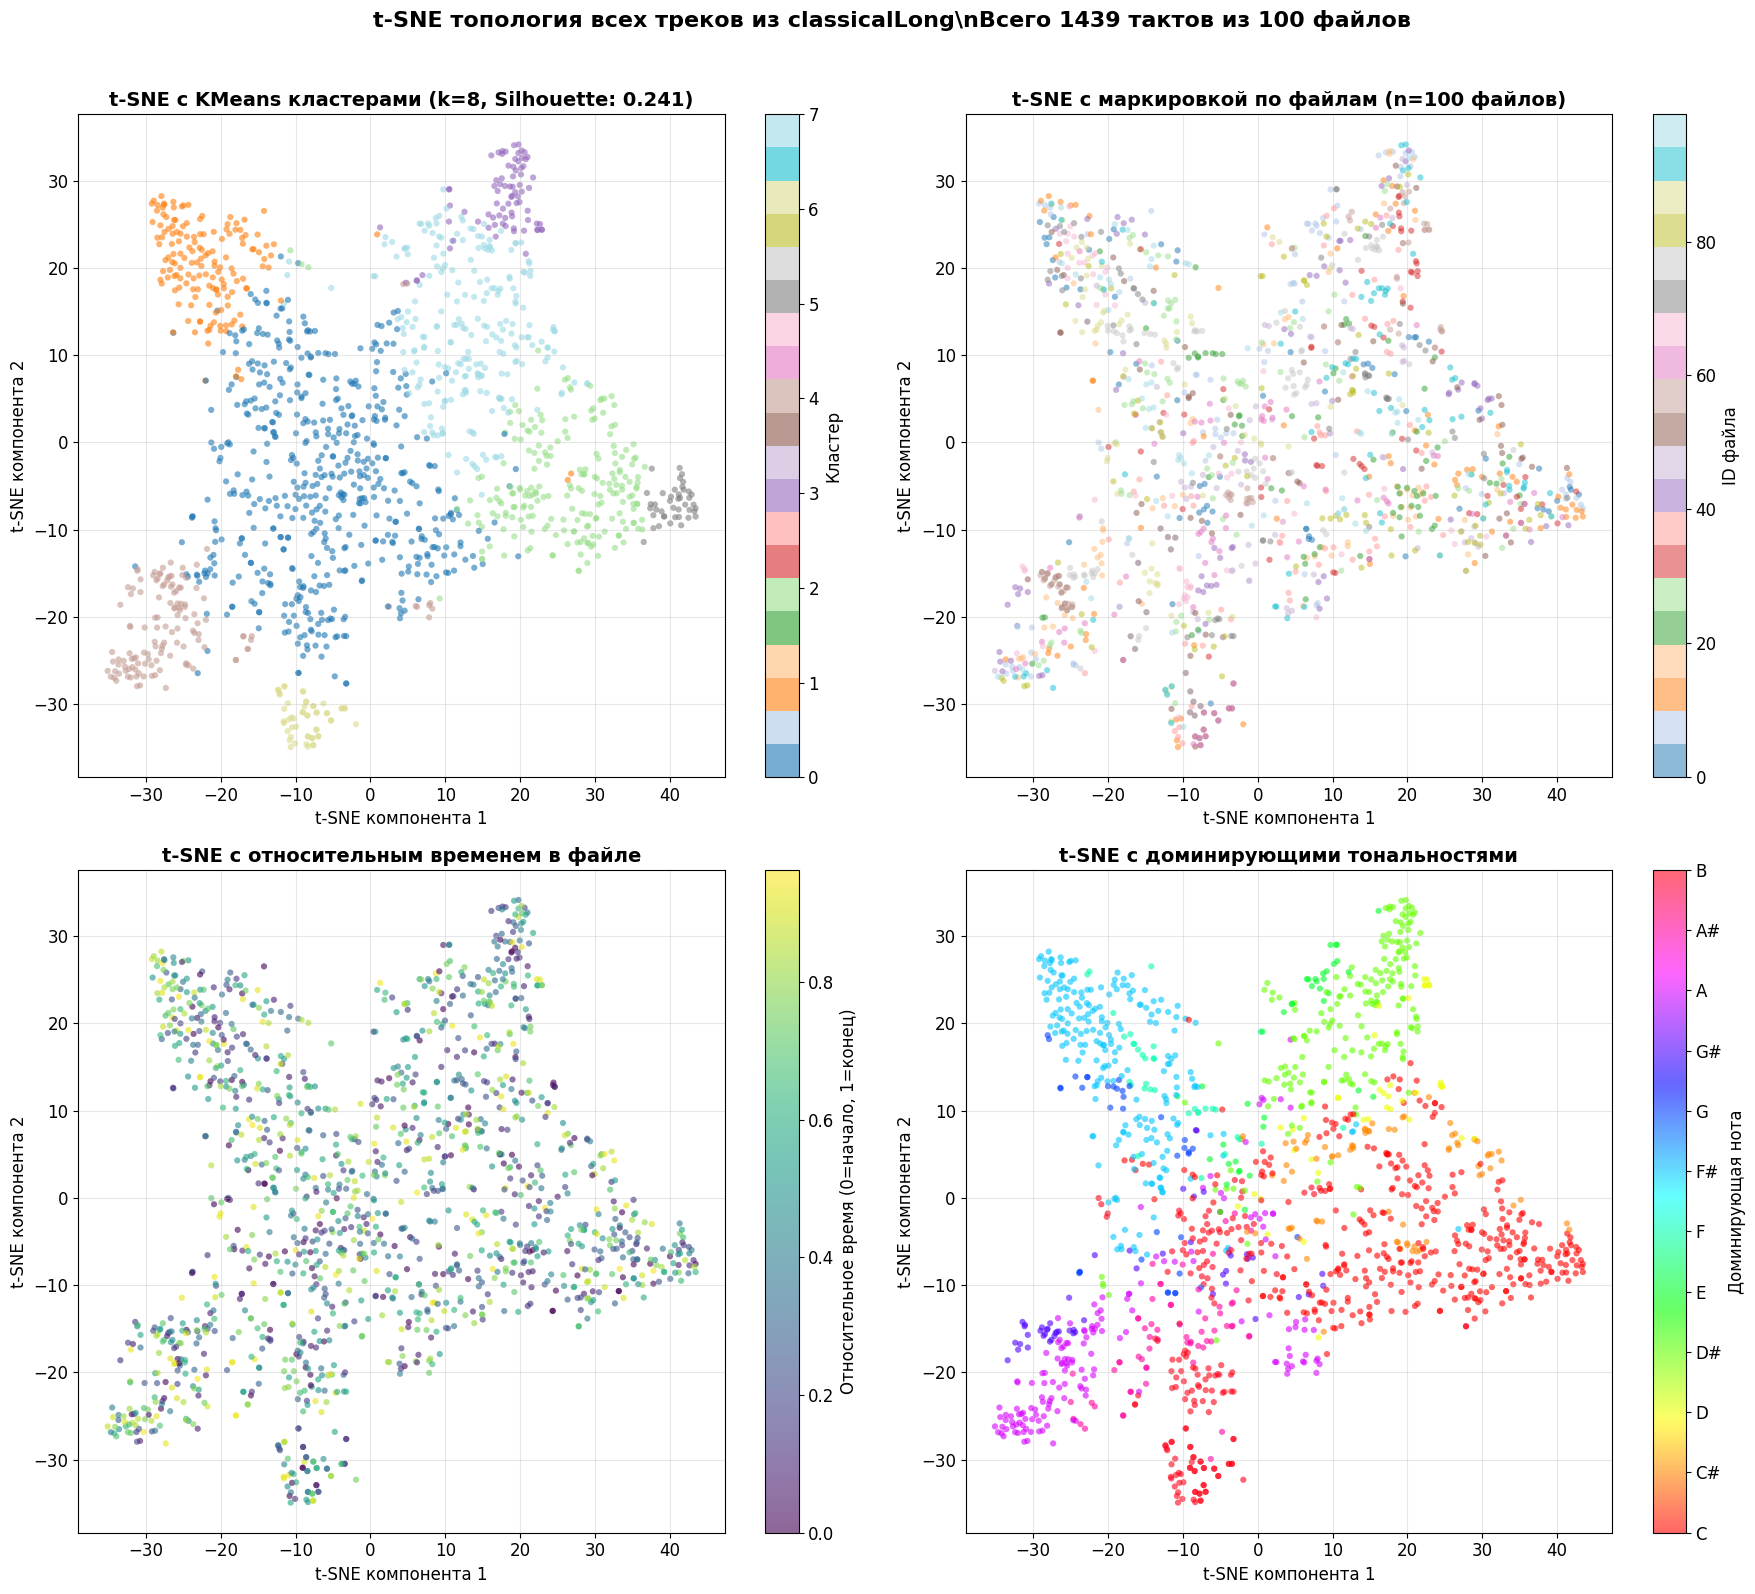

In [ ]:
# Создаём большую фигуру для визуализации
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# 1. t-SNE с кластерами
ax1 = axes[0, 0]
scatter1 = ax1.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=cluster_labels_all, cmap='tab20', 
                       s=20, alpha=0.6, edgecolors='none')
ax1.set_xlabel('t-SNE компонента 1', fontsize=12)
ax1.set_ylabel('t-SNE компонента 2', fontsize=12)
ax1.set_title(f't-SNE с KMeans кластерами (k={n_clusters_all}, Silhouette: {silhouette_avg_all:.3f})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Кластер')

# 2. t-SNE с файлами (цвет по файлу)
ax2 = axes[0, 1]
# Используем циклическую палитру для большего количества файлов
n_files = len(unique_files)
colors_file = plt.cm.tab20(np.linspace(0, 1, min(20, n_files)))
if n_files > 20:
    # Для больше 20 файлов используем HSV
    colors_file = plt.cm.hsv(np.linspace(0, 1, n_files))

file_colors_map = colors_file[file_ids % len(colors_file)]
scatter2 = ax2.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=file_ids, cmap='tab20', 
                       s=20, alpha=0.5, edgecolors='none')
ax2.set_xlabel('t-SNE компонента 1', fontsize=12)
ax2.set_ylabel('t-SNE компонента 2', fontsize=12)
ax2.set_title(f't-SNE с маркировкой по файлам (n={n_files} файлов)', 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='ID файла')

# 3. t-SNE с относительным временем в файле
ax3 = axes[1, 0]
scatter3 = ax3.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=relative_times, cmap='viridis', 
                       s=20, alpha=0.6, edgecolors='none')
ax3.set_xlabel('t-SNE компонента 1', fontsize=12)
ax3.set_ylabel('t-SNE компонента 2', fontsize=12)
ax3.set_title('t-SNE с относительным временем в файле', 
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Относительное время (0=начало, 1=конец)')

# 4. t-SNE с доминирующими тональностями
ax4 = axes[1, 1]
dominant_tones_all = np.argmax(combined_embeddings, axis=1)
scatter4 = ax4.scatter(embeddings_2d_all[:, 0], embeddings_2d_all[:, 1], 
                       c=dominant_tones_all, cmap='hsv', 
                       s=20, alpha=0.6, edgecolors='none')
ax4.set_xlabel('t-SNE компонента 1', fontsize=12)
ax4.set_ylabel('t-SNE компонента 2', fontsize=12)
ax4.set_title('t-SNE с доминирующими тональностями', 
              fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Доминирующая нота')
cbar4.set_ticks(range(12))
cbar4.set_ticklabels(chroma_names)

fig.suptitle(f't-SNE топология всех треков из classicalLong\\n'
             f'Всего {n_total_bars} тактов из {n_files} файлов', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


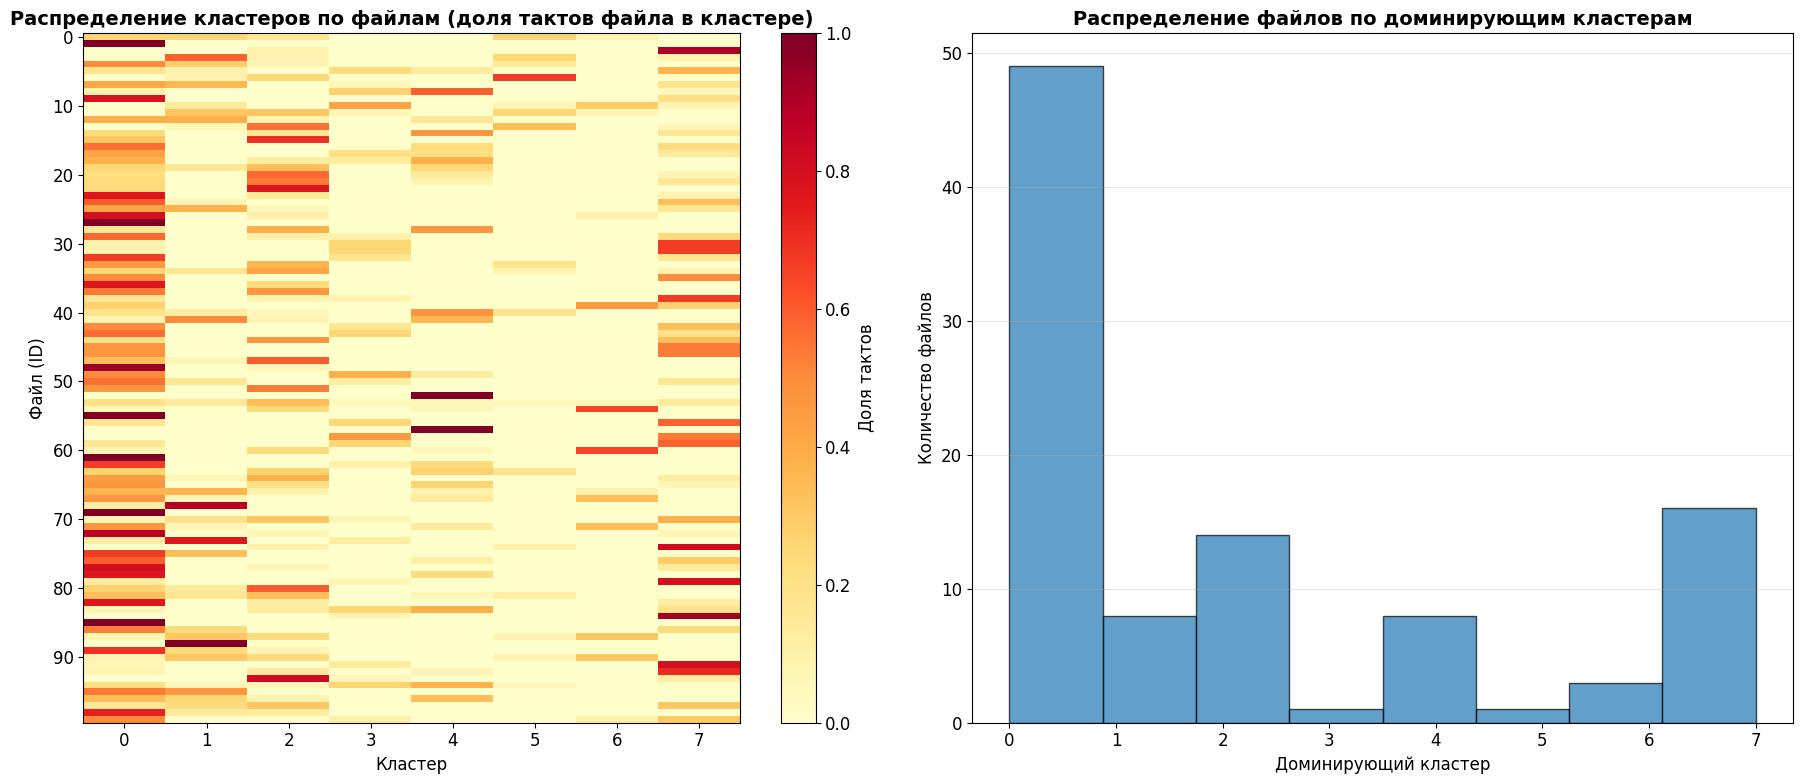

\nДетальная статистика по кластерам:
\nКластер 0:
  Всего тактов: 532 (37.0%)
  Файлов содержит: 87 (87.0% всех файлов)
  Средняя доля в файлах: 0.371
  Доминирующая тональность: B
  Средняя энтропия: 2.4805
\nКластер 1:
  Всего тактов: 154 (10.7%)
  Файлов содержит: 39 (39.0% всех файлов)
  Средняя доля в файлах: 0.105
  Доминирующая тональность: F#
  Средняя энтропия: 2.2578
\nКластер 2:
  Всего тактов: 209 (14.5%)
  Файлов содержит: 55 (55.0% всех файлов)
  Средняя доля в файлах: 0.145
  Доминирующая тональность: C
  Средняя энтропия: 2.3333
\nКластер 3:
  Всего тактов: 79 (5.5%)
  Файлов содержит: 30 (30.0% всех файлов)
  Средняя доля в файлах: 0.054
  Доминирующая тональность: D#
  Средняя энтропия: 2.0656
\nКластер 4:
  Всего тактов: 132 (9.2%)
  Файлов содержит: 32 (32.0% всех файлов)
  Средняя доля в файлах: 0.089
  Доминирующая тональность: A
  Средняя энтропия: 2.2703
\nКластер 5:
  Всего тактов: 42 (2.9%)
  Файлов содержит: 17 (17.0% всех файлов)
  Средняя доля в файлах: 0.0

In [ ]:
# Анализ: какие файлы попадают в какие кластеры
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Матрица: файл x кластер (процент тактов каждого файла в каждом кластере)
ax1 = axes[0]
cluster_distribution = np.zeros((len(unique_files), n_clusters_all))
for i, file_name in enumerate(unique_files):
    file_mask = file_names == file_name
    for cluster_id in range(n_clusters_all):
        cluster_mask = cluster_labels_all == cluster_id
        count = np.sum(file_mask & cluster_mask)
        total_bars_in_file = np.sum(file_mask)
        cluster_distribution[i, cluster_id] = count / total_bars_in_file if total_bars_in_file > 0 else 0

im = ax1.imshow(cluster_distribution, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax1.set_xlabel('Кластер', fontsize=12)
ax1.set_ylabel('Файл (ID)', fontsize=12)
ax1.set_title('Распределение кластеров по файлам (доля тактов файла в кластере)', 
              fontsize=14, fontweight='bold')
ax1.set_yticks(range(0, len(unique_files), max(1, len(unique_files)//10)))
ax1.set_xticks(range(n_clusters_all))
plt.colorbar(im, ax=ax1, label='Доля тактов')

# 2. Гистограмма количества файлов с доминирующим кластером
ax2 = axes[1]
dominant_cluster_per_file = []
for file_name in unique_files:
    file_mask = file_names == file_name
    file_clusters = cluster_labels_all[file_mask]
    if len(file_clusters) > 0:
        unique_file_clusters, counts = np.unique(file_clusters, return_counts=True)
        dominant_cluster = unique_file_clusters[np.argmax(counts)]
        dominant_cluster_per_file.append(dominant_cluster)

ax2.hist(dominant_cluster_per_file, bins=n_clusters_all, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Доминирующий кластер', fontsize=12)
ax2.set_ylabel('Количество файлов', fontsize=12)
ax2.set_title('Распределение файлов по доминирующим кластерам', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(range(n_clusters_all))
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Статистика по кластерам для всех файлов
print("\\nДетальная статистика по кластерам:")
print("=" * 80)
for cluster_id in range(n_clusters_all):
    cluster_mask = cluster_labels_all == cluster_id
    cluster_files = np.unique(file_names[cluster_mask])
    cluster_files_percent = 100 * len(cluster_files) / len(unique_files)
    
    print(f"\\nКластер {cluster_id}:")
    print(f"  Всего тактов: {np.sum(cluster_mask)} ({100*np.sum(cluster_mask)/n_total_bars:.1f}%)")
    print(f"  Файлов содержит: {len(cluster_files)} ({cluster_files_percent:.1f}% всех файлов)")
    print(f"  Средняя доля в файлах: {np.mean(cluster_distribution[:, cluster_id]):.3f}")
    
    # Доминирующая тональность в кластере
    cluster_embeddings = combined_embeddings[cluster_mask]
    cluster_mean = cluster_embeddings.mean(axis=0)
    dominant_tone_idx = np.argmax(cluster_mean)
    print(f"  Доминирующая тональность: {chroma_names[dominant_tone_idx]}")
    
    # Энтропия
    cluster_mean_norm = cluster_mean / (cluster_mean.sum() + 1e-9)
    cluster_entropy = -np.sum(cluster_mean_norm * np.log(cluster_mean_norm + 1e-9))
    print(f"  Средняя энтропия: {cluster_entropy:.4f}")
